## Calculate skill of S2S model ECMWF for daily global reforecasts

In [1]:
import climpred
import xarray as xr
import cartopy.crs as ccrs
from xclim.core import units
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import pandas as pd
from climpred.utils import convert_Timedelta_to_lead_units
import os

/home/egauillard/extreme_events_forecasting/extreme_events_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
s2s_ensemble_path = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/s2s_evaluation/s2s_tp_input.nc"
era_file_winter = "/home/egauillard/data/tp_1940_2023_1deg_7res_winter.nc"
# vae_ensemble_path = "/home/egauillard/extreme_events_forecasting/vae_probabilistic/experiments/VAE_20241013_185806_tp_fine_s_3Dlatent_in6_month9/s2s_inference_vae_combined/ensemble_predictions_combined.nc"
vae_ensemble_path = "/home/egauillard/extreme_events_forecasting/vae_probabilistic/experiments/VAE_20240920_194025_ld9000_beta7_gamma1000_every_coarse/s2s_inference_vae_combined/ensemble_predictions_combined.nc"
earthformer_ensemble_path = "/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/model/experiments/earthformer_era_20241013_202509_s_fine_tp_in8_0/s2s_inference_vae_combined/ensemble_predictions_combined.nc"

base_dir = os.path.dirname(vae_ensemble_path)

# Construire les chemins pour les différents fichiers
clim_std_path = os.path.join(base_dir, "climatology_std_combined.nc")
clim_mean_path = os.path.join(base_dir, "climatology_mean_combined.nc")
observations = os.path.join(base_dir, "ground_truth_combined.nc")

In [3]:
lead_times = [7,14, 21, 28]

### 1. Get the quantiles of the observations and verify observations are same values as ground truth

In [4]:
def load_and_preprocess_observations(file_path):
    obs = xr.open_dataset(file_path)
    obs_shifted = obs.copy()
    obs_shifted['time'] = obs_shifted['time'] - pd.Timedelta("7D")
    obs_shifted["tp"] = obs_shifted["tp"] * 7
    return obs_shifted

def compute_quantiles(obs):
    return (
        obs
        .quantile(q=[1 / 3, 2 / 3], dim="time", skipna=False)
        .rename({"quantile": "category_edge"})
    )


In [5]:
obs_shifted = load_and_preprocess_observations(era_file_winter)
obs_edges = compute_quantiles(obs_shifted)


In [6]:
obs = xr.open_dataset(observations)
obs.sel(forecast_time="2019-01-02").isel(latitude=0, longitude=0).tp.values 

array([9.27925110e-04, 1.24318600e-02, 1.00046599e+00, 9.49304104e-02])

In [7]:
obs_shifted.sel(time=obs_shifted.time.sel(time=["2019-01-02", "2019-01-09", "2019-01-16", "2019-01-23"])).isel(latitude=0, longitude=0).tp.values

array([9.2817831e-04, 1.2432275e-02, 1.0004659e+00, 9.4930984e-02],
      dtype=float32)

In [8]:
obs_edges

<xarray.Dataset>
Dimensions:        (longitude: 50, latitude: 15, category_edge: 2)
Coordinates:
  * longitude      (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0
  * latitude       (latitude) float32 31.0 32.0 33.0 34.0 ... 43.0 44.0 45.0
  * category_edge  (category_edge) float64 0.3333 0.6667
Data variables:
    tp             (category_edge, latitude, longitude) float64 0.2095 ... 18.79

### 2. Open S2S forecast data and adapt it to our forecast lead time

In [9]:
def load_and_preprocess_s2s(file_path, lead_times, med_lats=[45, 31], med_lons=[-10, 40]):
    s2s = xr.open_dataset(file_path)
    s2s = s2s.assign_coords(longitude=(((s2s.longitude + 180) % 360) - 180))
    # Tri des longitudes de -180 à 180
    s2s = s2s.sortby('longitude')
    s2s_tp = s2s["tp"]
    cutoff_date = pd.Timestamp("2020-12-03")
    s2s_tp = s2s_tp.sel(forecast_time=slice(None, cutoff_date))
    # Sélection de la région méditerranéenne
    s2s_tp = s2s_tp.sel(latitude=slice(med_lats[0], med_lats[1]), 
                        longitude=slice(med_lons[0], med_lons[1]))
    
    # Conversion des unités
    units.convert_units_to(s2s_tp, 'mm', "hydro")
    s2s_tp.attrs["units"] = "mm"

    # Réarrangement des latitudes dans l'ordre croissant
    lat_sort_index = np.argsort(s2s_tp.latitude.values)
    s2s_tp = s2s_tp.isel(latitude=lat_sort_index)

    # transformation des lead times en unités de temps
    s2s_tp = convert_Timedelta_to_lead_units(
        s2s_tp.rename({"lead_time": "lead"})
    )
    s2s_tp = s2s_tp.rename({"lead": "lead_time"})
    
    
    # Sélection des lead times et calcul des différences
    s2s_tp = s2s_tp.sel(lead_time=lead_times)
    for i in range(1, len(lead_times)):
        s2s_tp.loc[dict(lead_time=lead_times[i])] -= s2s_tp.sel(lead_time=lead_times[i-1])
    
    return s2s_tp


In [10]:
s2s_tp = load_and_preprocess_s2s(s2s_ensemble_path, lead_times)

In [11]:
s2s_tp.longitude

<xarray.DataArray 'longitude' (longitude: 33)>
array([-9. , -7.5, -6. , -4.5, -3. , -1.5,  0. ,  1.5,  3. ,  4.5,  6. ,  7.5,
        9. , 10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5,
       27. , 28.5, 30. , 31.5, 33. , 34.5, 36. , 37.5, 39. ])
Coordinates:
  * longitude  (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 34.5 36.0 37.5 39.0

### 3. Open models VAE and Earthformer predictions

In [12]:
vae_model = xr.open_dataset(vae_ensemble_path)["tp"]
earthformer_model = xr.open_dataset(earthformer_ensemble_path)["tp"]

vae_model = vae_model.sel(lead_time=lead_times)
earthformer_model = earthformer_model.sel(lead_time=lead_times)

clim_std = xr.open_dataset(clim_std_path)["tp"]
clim_mean = xr.open_dataset(clim_mean_path)["tp"]

clim_std = clim_std.sel(lead_time=lead_times)
clim_mean = clim_mean.sel(lead_time=lead_times)

### 4.  Map eveything to 1.5 degrees 

In [13]:
def regrid_sum(da, target_lat, target_lon):
    """
    Remaille un DataArray en sommant les valeurs dans chaque nouvelle cellule.
    
    :param da: xarray.DataArray d'entrée
    :param target_lat: latitudes cibles (de S2S)
    :param target_lon: longitudes cibles (de S2S)
    :return: DataArray remaillé
    """
    # Créer des bins pour les latitudes et longitudes
    lat_bins = np.concatenate([target_lat - 0.75, [target_lat[-1] + 0.75]])
    lon_bins = np.concatenate([target_lon - 0.75, [target_lon[-1] + 0.75]])
    
    # Regrouper et sommer
    regridded = da.groupby_bins('latitude', lat_bins).sum(dim='latitude')
    regridded = regridded.groupby_bins('longitude', lon_bins).sum(dim='longitude')
    
    # Renommer les dimensions
    regridded = regridded.rename({'latitude_bins': 'latitude', 'longitude_bins': 'longitude'})
    
    # Assigner les coordonnées correctes
    regridded['latitude'] = target_lat
    regridded['longitude'] = target_lon
    
    return regridded

In [14]:

vae_regridded = regrid_sum(vae_model, s2s_tp.latitude, s2s_tp.longitude)
earthformer_regridded = regrid_sum(earthformer_model, s2s_tp.latitude, s2s_tp.longitude)
obs_edges_regridded = regrid_sum(obs_edges, s2s_tp.latitude, s2s_tp.longitude)
obs_shifted_regridded = regrid_sum(obs_shifted, s2s_tp.latitude, s2s_tp.longitude)
clim_std_regridded = regrid_sum(clim_std, s2s_tp.latitude, s2s_tp.longitude)
clim_mean_regridded = regrid_sum(clim_mean, s2s_tp.latitude, s2s_tp.longitude)
obs_regridded = regrid_sum(obs, s2s_tp.latitude, s2s_tp.longitude)


In [15]:
def remove_duplicates(ds, name):
    print(f"\nTraitement de {name}:")
    print(f"Nombre initial de forecast_time: {ds.sizes['forecast_time']}")
    
    # Supprimer les doublons, en gardant la première occurrence
    ds_unique = ds.drop_duplicates(dim='forecast_time')
    
    print(f"Nombre de forecast_time après suppression des doublons: {ds_unique.sizes['forecast_time']}")
    print(f"Nombre de doublons supprimés: {ds.sizes['forecast_time'] - ds_unique.sizes['forecast_time']}")
    
    return ds_unique

# Appliquer la suppression des doublons à vae_regridded
vae_regridded = remove_duplicates(vae_regridded, "vae_regridded")
earthformer_regridded = remove_duplicates(earthformer_regridded, "earthformer_gridded")
clim_mean_regridded = remove_duplicates(clim_mean_regridded, "clim_mean_regridded")
clim_std_regridded = remove_duplicates(clim_std_regridded, "clim_std_regridded")
obs_regridded = remove_duplicates(obs_regridded, "obs_regridded")


Traitement de vae_regridded:
Nombre initial de forecast_time: 145
Nombre de forecast_time après suppression des doublons: 129
Nombre de doublons supprimés: 16

Traitement de earthformer_gridded:
Nombre initial de forecast_time: 125
Nombre de forecast_time après suppression des doublons: 117
Nombre de doublons supprimés: 8

Traitement de clim_mean_regridded:
Nombre initial de forecast_time: 145
Nombre de forecast_time après suppression des doublons: 129
Nombre de doublons supprimés: 16

Traitement de clim_std_regridded:
Nombre initial de forecast_time: 145
Nombre de forecast_time après suppression des doublons: 129
Nombre de doublons supprimés: 16

Traitement de obs_regridded:
Nombre initial de forecast_time: 145
Nombre de forecast_time après suppression des doublons: 129
Nombre de doublons supprimés: 16


In [16]:
# the forecast_time in common of the 3 models
common_forecast_times = np.intersect1d(s2s_tp.forecast_time, vae_model.forecast_time)
common_forecast_times = np.intersect1d(common_forecast_times, earthformer_model.forecast_time)

s2s_tp_regridded = s2s_tp.sel(forecast_time=common_forecast_times)
vae_regridded = vae_regridded.sel(forecast_time=common_forecast_times)
earthformer_regridded = earthformer_regridded.sel(forecast_time=common_forecast_times)
clim_mean_regridded = clim_mean_regridded.sel(forecast_time=common_forecast_times)
clim_std_regridded = clim_std_regridded.sel(forecast_time=common_forecast_times)
obs_regridded = obs_regridded.sel(forecast_time=common_forecast_times)



In [17]:
period = slice(13,55)


s2s_tp_regridded = s2s_tp_regridded.isel(forecast_time=period)
vae_regridded = vae_regridded.isel(forecast_time=period)
earthformer_regridded = earthformer_regridded.isel(forecast_time=period)
clim_mean_regridded = clim_mean_regridded.isel(forecast_time=period)
clim_std_regridded = clim_std_regridded.isel(forecast_time=period)


In [18]:
vae_regridded.forecast_time

<xarray.DataArray 'forecast_time' (forecast_time: 42)>
array(['2017-01-16T00:00:00.000000000', '2017-01-23T00:00:00.000000000',
       '2017-01-30T00:00:00.000000000', '2017-02-06T00:00:00.000000000',
       '2017-02-13T00:00:00.000000000', '2017-02-20T00:00:00.000000000',
       '2017-11-19T00:00:00.000000000', '2017-11-26T00:00:00.000000000',
       '2017-12-03T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-30T00:00:00.000000000',
       '2018-02-06T00:00:00.000000000', '2018-02-13T00:00:00.000000000',
       '2018-02-20T00:00:00.000000000', '2018-11-19T00:00:00.000000000',
       '2018-11-26T00:00:00.000000000', '2018-12-03T00:00:00.000000000',
       '2019-01-02T00:00:00.000000000', '2019-01-09T00:00:00.000000000',
       '2019-01-16T00:00:00.000000000', '2019-01-23T00:00:00.000000000',
       '2019-01-30T00:00:00.000000000', '2019-02-06T00:00:00.000000000',
       '2019-02-13T00:00:00.000000000', '2019-02-20T00:00:00.000000000',
       '2019-11-19T00:00:00.000000000', '2019-11-26T00:00:00.000000000',
       '2019-12-03T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-09T00:00:00.000000000', '2020-01-16T00:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-30T00:00:00.000000000',
       '2020-02-06T00:00:00.000000000', '2020-02-13T00:00:00.000000000',
       '2020-02-20T00:00:00.000000000', '2020-11-19T00:00:00.000000000',
       '2020-11-26T00:00:00.000000000', '2020-12-03T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2017-01-16 ... 2020-12-03

### 5. Generate climatology gaussian

In [19]:
def generate_clim_ensemble(clim_mean, clim_std, num_realizations=50):
    """
    Génère un ensemble climatologique basé sur une distribution gaussienne.
    
    :param clim_mean: xarray.DataArray de la moyenne climatologique
    :param clim_std: xarray.DataArray de l'écart-type climatologique
    :param s2s_reference: xarray.DataArray de référence S2S pour les dimensions
    :param num_realizations: Nombre de réalisations à générer
    :return: xarray.DataArray de l'ensemble climatologique
    """
    # Créez un tableau de nombres aléatoires gaussiens
    random_samples = np.random.normal(
        loc=0, 
        scale=1, 
        size=(num_realizations,) + clim_mean.shape
    )
    
    # Créez l'ensemble climatologique
    clim_ensemble = (clim_mean.values + clim_std.values * random_samples)
    # clim_ensemble = clim_mean.values + 0 * random_samples
    
    # Créez un xarray.DataArray avec les bonnes dimensions et coordonnées
    clim_ensemble_da = xr.DataArray(
        clim_ensemble,
        coords={
            'realization': np.arange(num_realizations),
            'forecast_time': clim_mean.forecast_time,
            'lead_time': clim_mean.lead_time,
            'latitude': clim_mean.latitude,
            'longitude': clim_mean.longitude
        },
        dims=['realization', 'forecast_time','lead_time',  'latitude', 'longitude']
    )
    # faire dataset avec variable tp
    clim_ensemble_da = clim_ensemble_da.to_dataset(name="tp")
    return clim_ensemble_da
    
clim_ensemble = generate_clim_ensemble(clim_mean_regridded, clim_std_regridded)

## Part 2 Compute RPSS, BSS, ACC and RMSE/per lead time

In [20]:
obs_edges_regridded 

<xarray.Dataset>
Dimensions:        (longitude: 33, latitude: 10, category_edge: 2)
Coordinates:
  * category_edge  (category_edge) float64 0.3333 0.6667
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * longitude      (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 36.0 37.5 39.0
Data variables:
    tp             (longitude, latitude, category_edge) float64 1.464 ... 18.79

In [21]:
def compute_metrics(forecast, observations, obs_edges):
    # Prepare data for climpred
    forecast = forecast.rename({'forecast_time': 'init', 'lead_time': 'lead', 'realization': 'member'})
    forecast["lead"].attrs["units"] = "days"
    
    # Create PerfectModelEnsemble object
    pm = climpred.HindcastEnsemble(forecast)
    pm = pm.add_observations(observations)

    

    # Compute metrics
    rps = pm.verify(metric='rps', category_edges=obs_edges, comparison='m2o', dim=['init','member'], alignment='same_inits')
    rmse = pm.verify(metric='rmse', comparison='e2o', dim='init', alignment='same_inits')
    
    return rps, rmse

# Compute metrics for each model
rps_s2s,  rmse_s2s = compute_metrics(s2s_tp_regridded, obs_shifted_regridded, obs_edges_regridded)
rps_vae,  rmse_vae = compute_metrics(vae_regridded, obs_shifted_regridded, obs_edges_regridded)
rps_earthformer, rmse_earthformer = compute_metrics(earthformer_regridded, obs_shifted_regridded, obs_edges_regridded)
rps_clim, rmse_clim = compute_metrics(clim_ensemble, obs_shifted_regridded, obs_edges_regridded)

In [22]:
lead_times 

[7, 14, 21, 28]

In [23]:
def compute_deterministic(forecast, obs, clim_mean):
    """
    Calcule les métriques déterministes (ACC, RMSE) pour les prévisions météorologiques.
    
    Parameters:
    forecast (xarray.DataArray): Prévisions (s2s_tp, vae_regridded, ou earthformer_regridded)
    obs (xarray.DataArray): Observations (obs_regridded)
    clim_mean (xarray.DataArray): Moyenne climatologique (clim_mean)
    
    Returns:
    dict: Dictionnaire contenant ACC et RMSE moyennés sur forecast_time
    """
    
    # Calcul de l'ACC
    forecast_anom = forecast - clim_mean
    obs_anom = obs - clim_mean
    
    numerator = (forecast_anom * obs_anom).mean(dim='forecast_time')
    denominator = np.sqrt((forecast_anom**2).mean(dim='forecast_time') * (obs_anom**2).mean(dim='forecast_time'))
    acc = numerator / denominator

    # Calcul du RMSE
    rmse = np.sqrt(((forecast.mean("realization") - obs)**2).mean(dim='forecast_time'))
    rmse_dist = np.sqrt(((forecast.mean("realization") - obs)**2))

    return {'ACC': acc, 'RMSE': rmse, 'RMSE_dist': rmse_dist}


det_s2s_metrics = compute_deterministic(s2s_tp_regridded, obs_regridded, clim_mean_regridded)
det_vae_metrics = compute_deterministic(vae_regridded, obs_regridded, clim_mean_regridded)
det_earthformer_metrics = compute_deterministic(earthformer_regridded, obs_regridded, clim_mean_regridded)
climatology = compute_deterministic(clim_ensemble, obs_regridded, clim_mean_regridded)

rmse_earthformer_det = det_earthformer_metrics["RMSE"]
rmse_vae_det = det_vae_metrics["RMSE"]
rmse_s2s_det = det_s2s_metrics["RMSE"]
rmse_clim_det = climatology["RMSE"]

In [24]:
disrt_earthformer = [det_earthformer_metrics["RMSE_dist"].mean(["latitude", "longitude"]).tp.isel(lead_time = i).values for i in range(4)]
disrt_vae = [det_vae_metrics["RMSE_dist"].mean(["latitude", "longitude"]).tp.isel(lead_time = i).values for i in range(4)]
disrt_s2s = [det_s2s_metrics["RMSE_dist"].mean(["latitude", "longitude"]).tp.isel(lead_time = i).values for i in range(4)]
disrt_clim = [climatology["RMSE_dist"].mean(["latitude", "longitude"]).tp.isel(lead_time = i).values for i in range(4)]


In [25]:

len(disrt_clim[0])


42

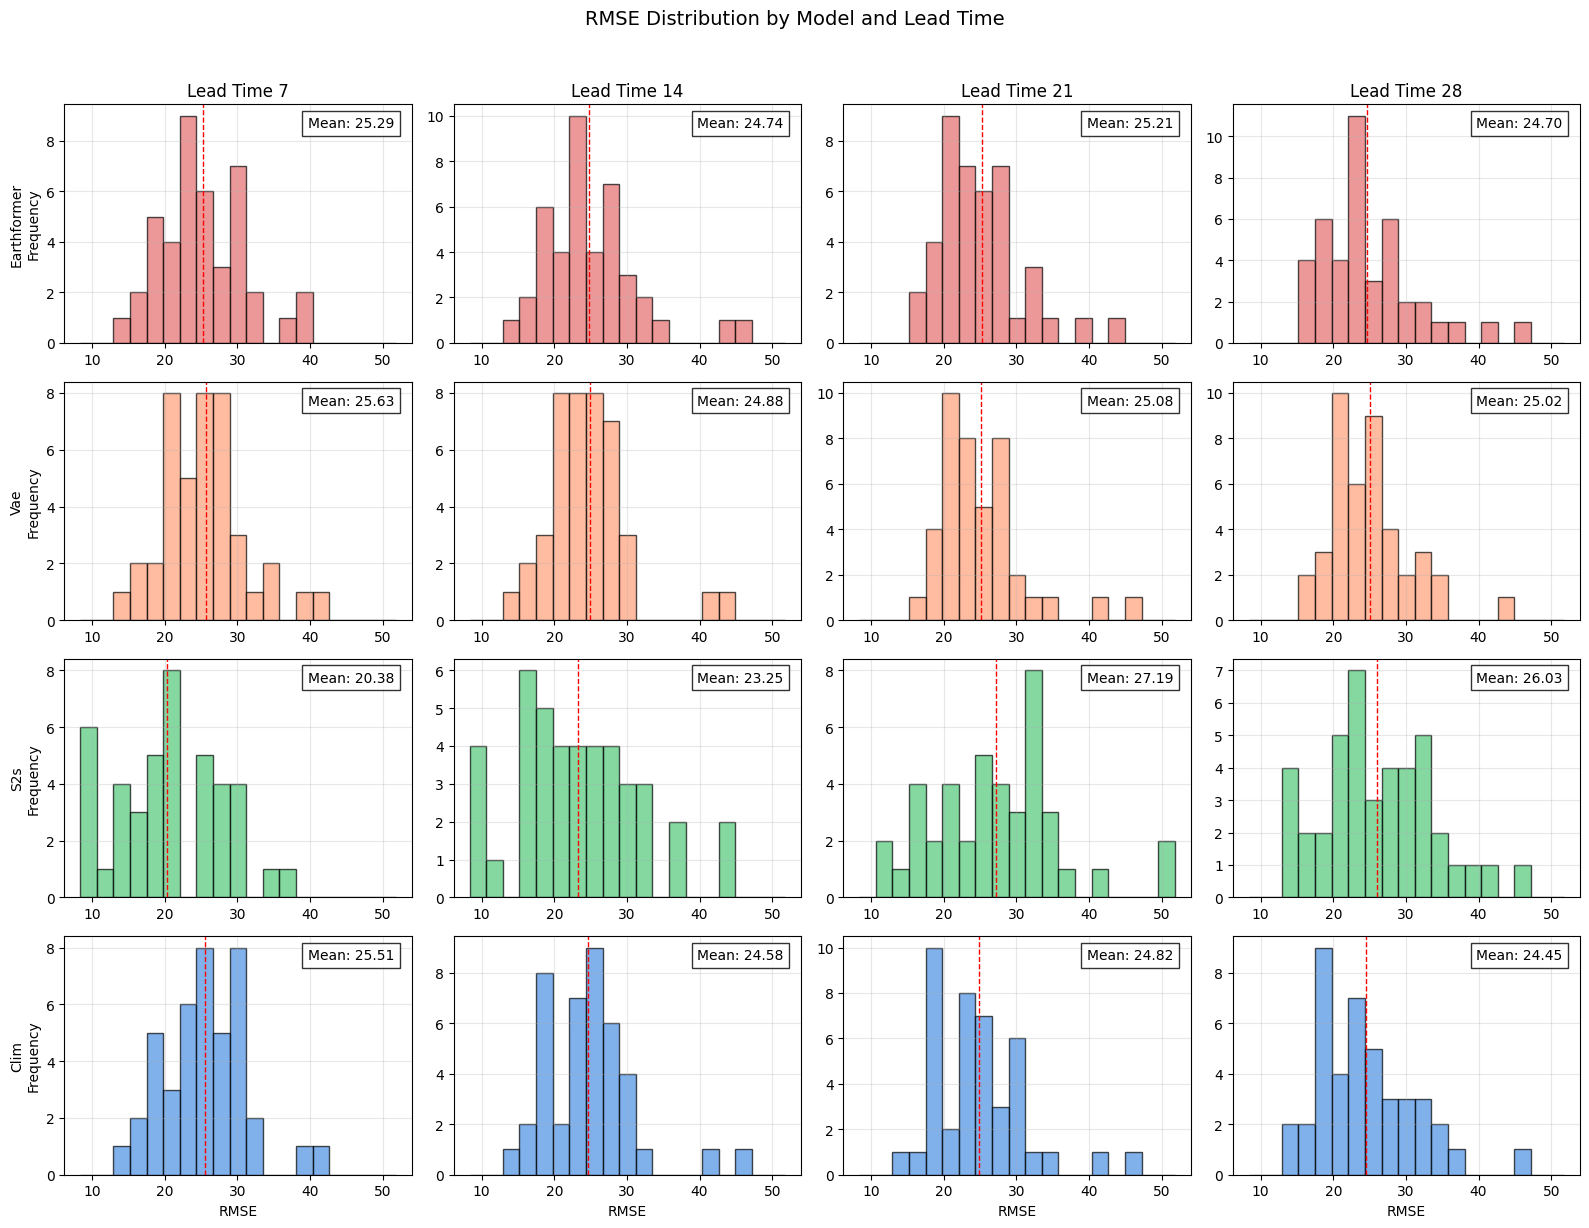

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rmse_distributions_grid(dist_data_dict, lead_times, n_bins=20):
    """
    Plot RMSE distributions in a grid: one row per model, one column per lead time.
    
    Parameters:
    -----------
    dist_data_dict : dict
        Dictionary containing model names and their RMSE distributions
    lead_times : list or array
        List of lead time values
    n_bins : int
        Number of bins for histogram
    """
    # Define colors
    colors = {
        'clim': "#4A90E2",        # Soft blue
        's2s': "#50C878",         # Emerald green
        'earthformer': "#E66C6C", # Soft red
        'vae': "#FFA07A"          # Light salmon
    }
    
    # Create figure with subplots: one row per model, one column per lead time
    fig, axes = plt.subplots(len(dist_data_dict), len(lead_times), 
                            figsize=(4*len(lead_times), 3*len(dist_data_dict)))
    fig.suptitle('RMSE Distribution by Model and Lead Time', fontsize=14, y=1.02)
    
    # Calculate global min and max for consistent bins across subplots
    all_values = np.concatenate([np.concatenate(list(dist_data_dict.values()))])
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    bins = np.linspace(global_min, global_max, n_bins)
    
    # Plot distribution for each model and lead time
    for i, (model_name, dist_data) in enumerate(dist_data_dict.items()):
        for j, lead_time in enumerate(lead_times):
            ax = axes[i, j]
            
            # Create histogram
            ax.hist(dist_data[j], bins=bins, 
                   color=colors[model_name],
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=1)
            
            # Add mean line
            mean = np.mean(dist_data[j])
            ax.axvline(mean, color='red', 
                      linestyle='--', 
                      linewidth=1)
            
            # Add mean value text
            ax.text(0.95, 0.95, f'Mean: {mean:.2f}',
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(facecolor='white', alpha=0.8))
            
            # Customize plot
            if j == 0:  # First column
                ax.set_ylabel(f'{model_name.capitalize()}\nFrequency')
            if i == len(dist_data_dict)-1:  # Last row
                ax.set_xlabel('RMSE')
            if i == 0:  # First row
                ax.set_title(f'Lead Time {lead_time}')
            
            # Add grid
            ax.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Create dictionary of distributions
dist_data_dict = {
    'earthformer': disrt_earthformer,
    'vae': disrt_vae,
    's2s': disrt_s2s,
    'clim': disrt_clim
}

# Create the plot
fig = plot_rmse_distributions_grid(dist_data_dict, lead_times)
plt.show()

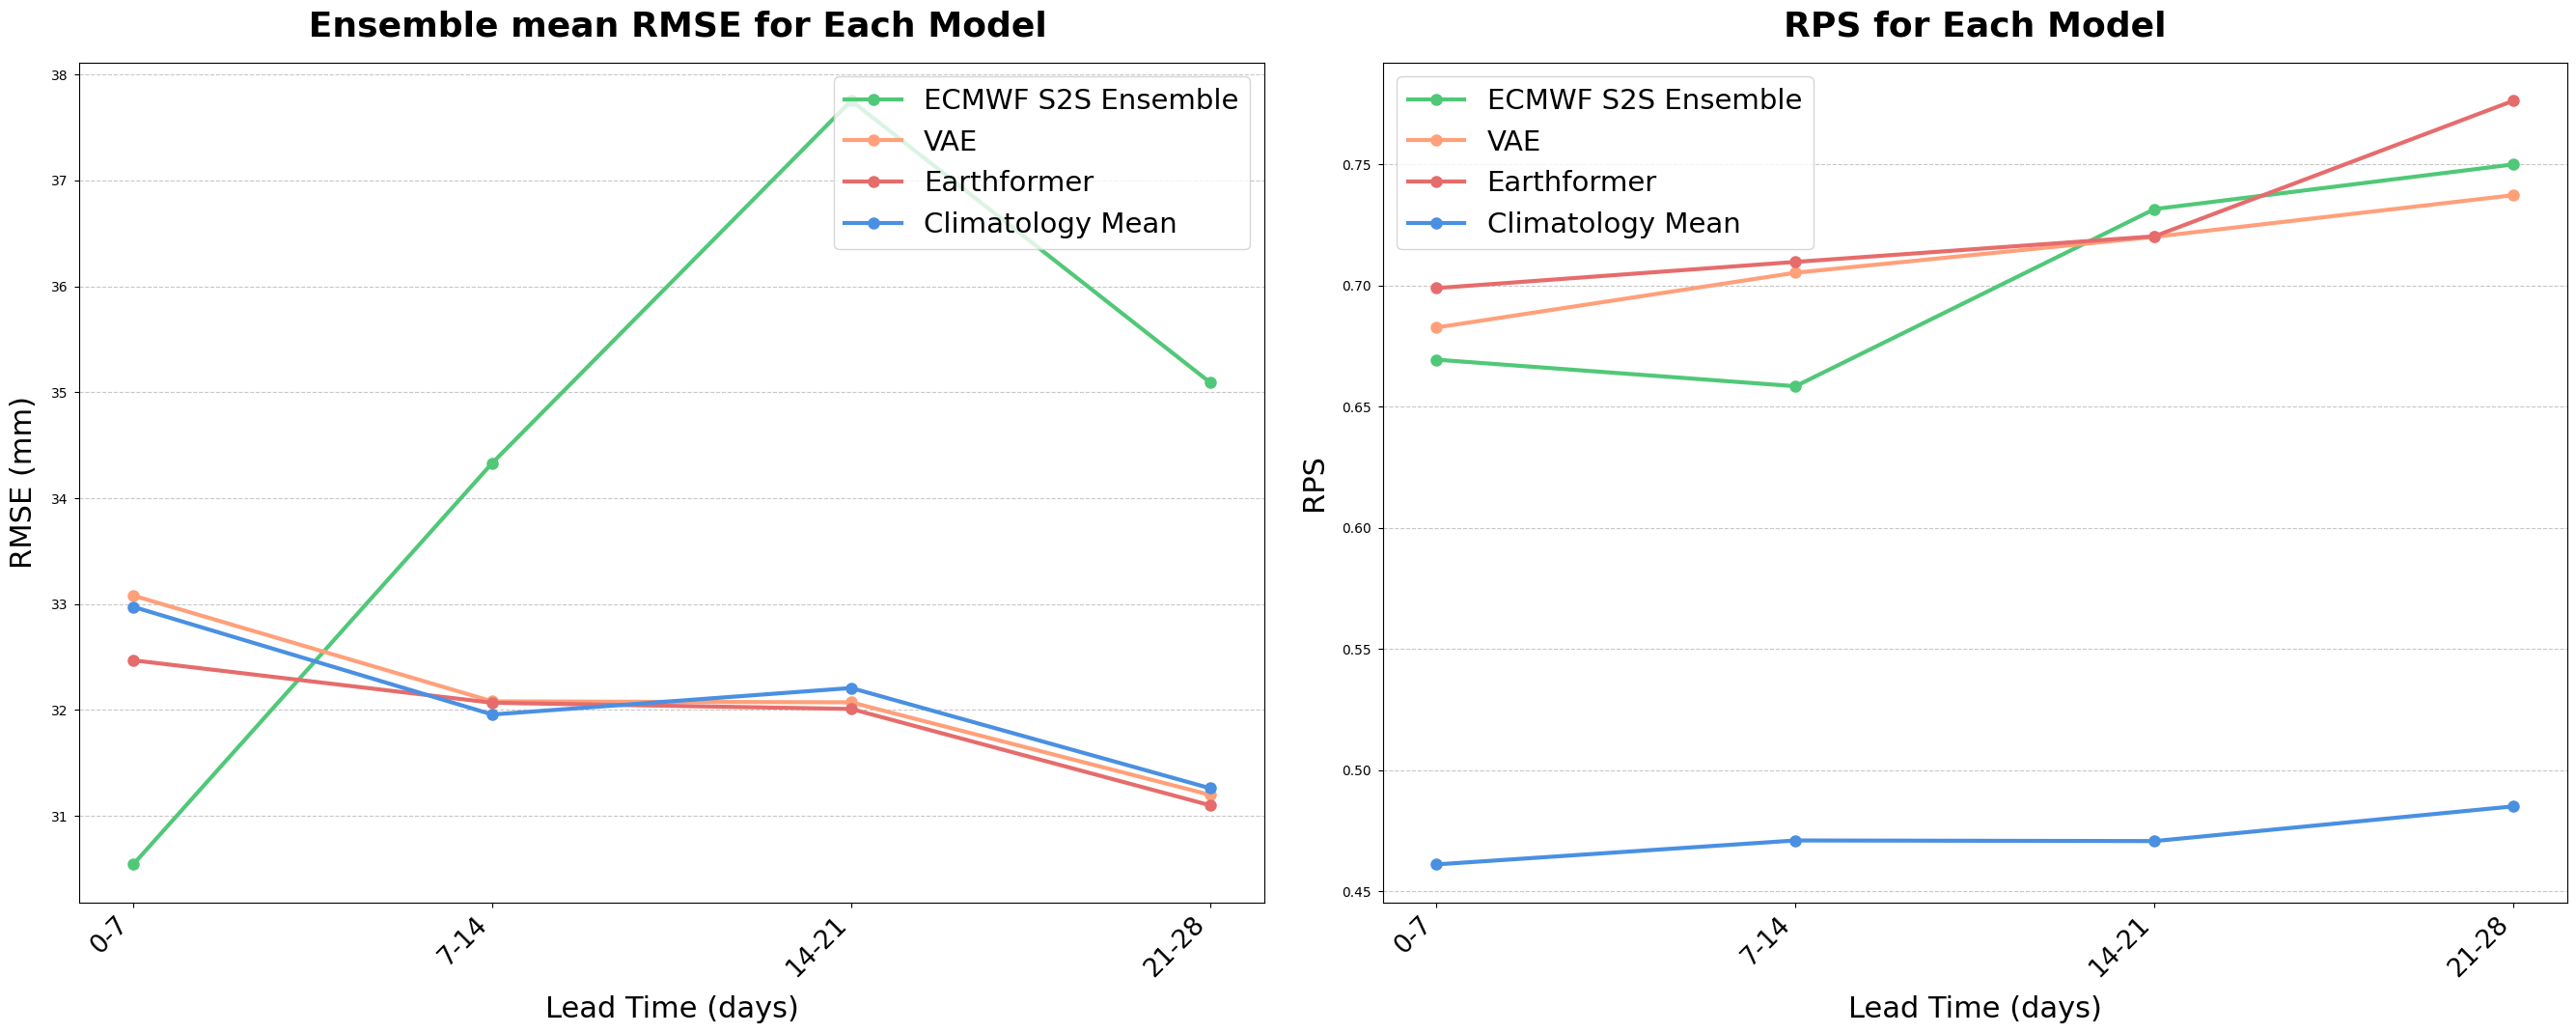

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Set up a nicer color palette
clim_color = "#4A90E2"  # Soft blue
s2s_color = "#50C878"   # Emerald green
earthformer_color = "#E66C6C"  # Soft red
vae_color = "#FFA07A"   # Light salmon

# Reduce figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))

# Set global font sizes
plt.rcParams['font.size'] = 18  # Adjust the default font size
plt.rcParams['axes.titlesize'] = 20  # Adjust title size
plt.rcParams['axes.labelsize'] = 20  # Adjust axis label size
plt.rcParams['xtick.labelsize'] = 17  # Adjust x-tick label size
plt.rcParams['ytick.labelsize'] = 19 # Adjust y-tick label size
plt.rcParams['legend.fontsize'] = 20 # Adjust legend font size

# Function to plot data with points
def plot_with_points(ax, data, color, label):
    ax.plot(lead_times, data, color=color, label=label, marker='o', linestyle='-', markersize=8, linewidth=3)

# Function to generate custom lead time labels
def generate_lead_time_labels(lead_times):
    return [f"{lt-7}-{lt}" for lt in lead_times]

custom_labels = generate_lead_time_labels(lead_times)

# Plot RMSE
plot_with_points(ax1, rmse_s2s_det.tp.mean(dim=['latitude', 'longitude']), s2s_color, 'ECMWF S2S Ensemble')
plot_with_points(ax1, rmse_vae_det.tp.mean(dim=['latitude', 'longitude']), vae_color, 'VAE')
plot_with_points(ax1, rmse_earthformer_det.tp.mean(dim=['latitude', 'longitude']), earthformer_color, 'Earthformer')
plot_with_points(ax1, rmse_clim_det.tp.mean(dim=['latitude', 'longitude']), clim_color, 'Climatology Mean')

ax1.set_xlabel('Lead Time (days)', fontsize=22, labelpad=10)
ax1.set_ylabel('RMSE (mm)', fontsize=22, labelpad=10)
ax1.legend(fontsize=21, loc='upper right')
ax1.set_title(' Ensemble mean RMSE for Each Model', fontsize=26, pad=20, weight = 'bold')
ax1.set_xticks(lead_times)
ax1.set_xticklabels(custom_labels, rotation=45, ha='right', fontsize=19)
ax1.tick_params(axis='y', which='major', pad=5)
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Plot RPS
plot_with_points(ax2, rps_s2s.tp.mean(dim=['latitude', 'longitude']), s2s_color, 'ECMWF S2S Ensemble')
plot_with_points(ax2, rps_vae.tp.mean(dim=['latitude', 'longitude']), vae_color, 'VAE')
plot_with_points(ax2, rps_earthformer.tp.mean(dim=['latitude', 'longitude']), earthformer_color, 'Earthformer')
plot_with_points(ax2, rps_clim.tp.mean(dim=['latitude', 'longitude']), clim_color, 'Climatology Mean')

ax2.set_xlabel('Lead Time (days)', fontsize=22, labelpad=10)
ax2.set_ylabel('RPS', fontsize=22, labelpad=10)
ax2.legend(fontsize=21, loc='upper left')
ax2.set_title('RPS for Each Model', fontsize=26, pad=20, weight = 'bold')
ax2.set_xticks(lead_times)
ax2.set_xticklabels(custom_labels, rotation=45, ha='right', fontsize=19)
ax2.tick_params(axis='y', which='major', pad=5)
ax2.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to reduce space between the plots
plt.tight_layout(pad=3.0, w_pad=1.5)  # Reduced w_pad value to 1.5 for less space
fig.patch.set_facecolor('#FFFFFF')  # White background for the entire figure
plt.show()

# Save the figure with tight bounding box
plt.savefig("metrics.png", bbox_inches='tight', dpi=300)


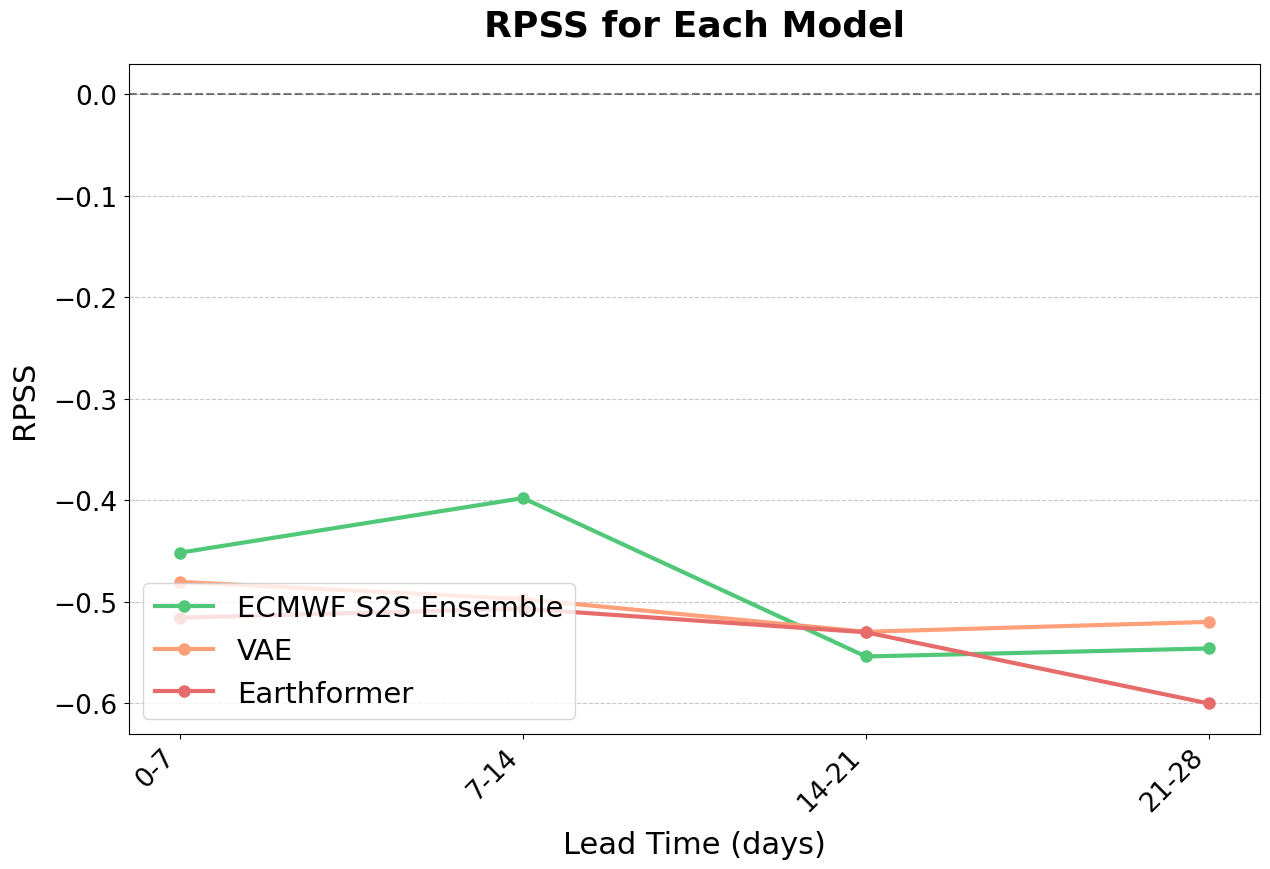

In [28]:
# plot rpss 

rpss_s2s_lead = 1-rps_s2s.tp.mean(dim=['latitude', 'longitude'])/rps_clim.tp.mean(dim=['latitude', 'longitude'])
rpss_vae_lead = 1-rps_vae.tp.mean(dim=['latitude', 'longitude'])/rps_clim.tp.mean(dim=['latitude', 'longitude'])
rpss_earthformer_lead = 1-rps_earthformer.tp.mean(dim=['latitude', 'longitude'])/rps_clim.tp.mean(dim=['latitude', 'longitude'])

import matplotlib.pyplot as plt
import numpy as np

# Configuration des couleurs
s2s_color = "#50C878"   # Vert émeraude
vae_color = "#FFA07A"   # Saumon clair
earthformer_color = "#E66C6C"  # Rouge doux

# Configuration de la figure
plt.rcParams['font.size'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 19
plt.rcParams['legend.fontsize'] = 20

# Création de la figure
fig, ax = plt.subplots(figsize=(14, 10))

# Fonction pour tracer les données avec des points
def plot_with_points(ax, data, color, label):
    ax.plot(lead_times, data, color=color, label=label, marker='o', 
            linestyle='-', markersize=8, linewidth=3)

# Fonction pour générer les étiquettes de temps
def generate_lead_time_labels(lead_times):
    return [f"{lt-7}-{lt}" for lt in lead_times]

custom_labels = generate_lead_time_labels(lead_times)

# Tracer les courbes RPSS
plot_with_points(ax, rpss_s2s_lead, s2s_color, 'ECMWF S2S Ensemble')
plot_with_points(ax, rpss_vae_lead, vae_color, 'VAE')
plot_with_points(ax, rpss_earthformer_lead, earthformer_color, 'Earthformer')


# Configuration des axes et labels
ax.set_xlabel('Lead Time (days)', fontsize=22, labelpad=10)
ax.set_ylabel('RPSS', fontsize=22, labelpad=10)
ax.legend(fontsize=21, loc='lower left')
ax.set_title('RPSS for Each Model', fontsize=26, pad=20, weight='bold')
ax.set_xticks(lead_times)
ax.set_xticklabels(custom_labels, rotation=45, ha='right', fontsize=19)
ax.tick_params(axis='y', which='major', pad=5)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Ajout d'une ligne horizontale à y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Ajustement de la mise en page
plt.tight_layout(pad=3.0)
fig.patch.set_facecolor('#FFFFFF')

plt.savefig("rpss.png", bbox_inches='tight', dpi=300)
plt.show()


/scratch-local/69627/ipykernel_1800981/1581313363.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


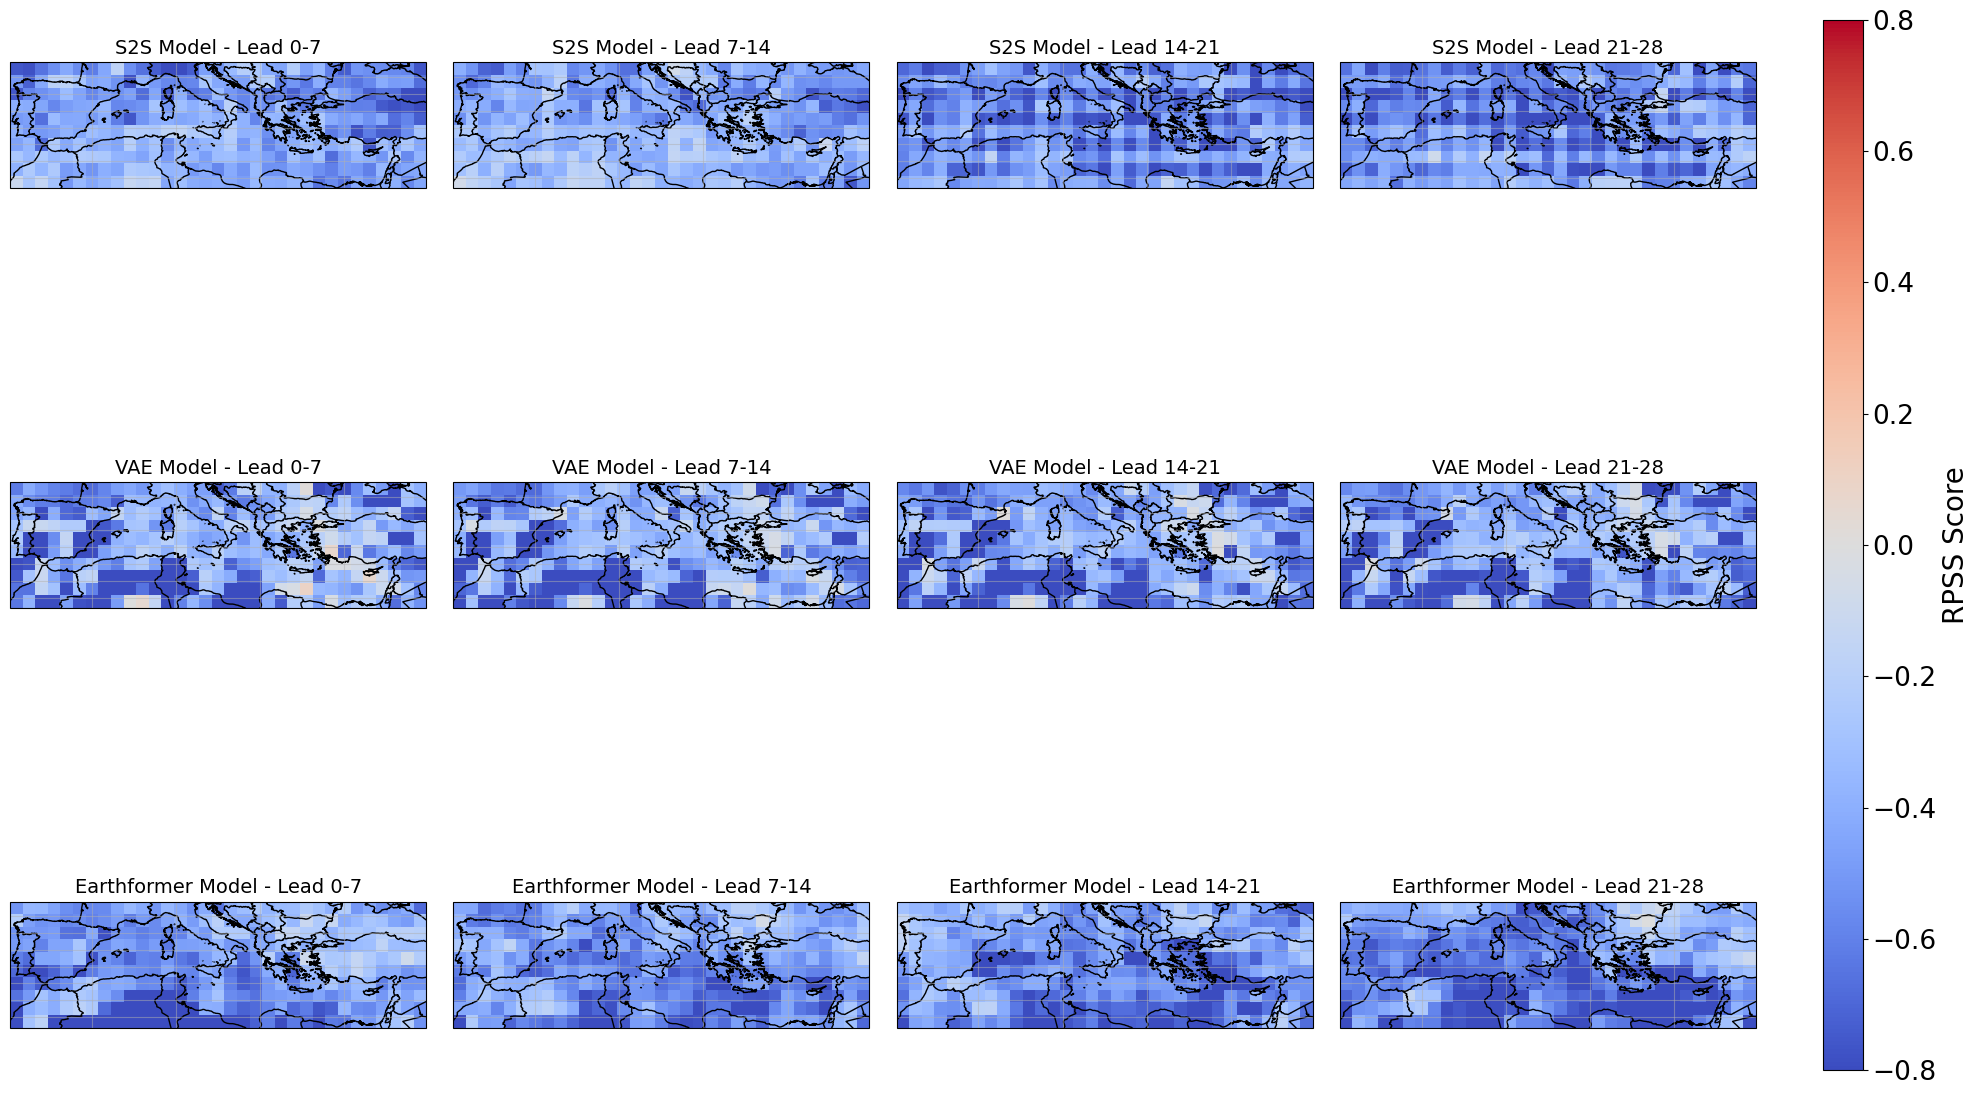

In [29]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Function to generate custom lead time labels
def generate_lead_time_labels(lead_times):
    return [f"{lt-7}-{lt}" for lt in lead_times]

# Suppose rps_s2s, rps_vae, rps_earthformer, and rps_clim are xarray DataArrays
# rps_s2s, rps_vae, rps_earthformer, and rps_clim should contain a 'lead' dimension
# rps_s2s, rps_vae, rps_earthformer, rps_clim = <your data>

# List of models and their RPSS values to be computed
models = {'S2S Model': rps_s2s, 'VAE Model': rps_vae, 'Earthformer Model': rps_earthformer}

# Set lead times and generate labels
custom_labels = generate_lead_time_labels(lead_times)

# Create figure
fig, axes = plt.subplots(len(models), len(lead_times), figsize=(5 * len(lead_times), 5 * len(models)), 
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Function to add map features
def add_map_features(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=False, alpha=0.5)

# Set color scale limits for RPSS
vmin = -0.8
vmax = 0.8

# Loop over models and lead times to plot RPSS maps
for row, (model_name, model_data) in enumerate(models.items()):
    for col, lead_time in enumerate(lead_times):
        # Compute RPSS for the current lead time
        rpss = 1 - model_data.isel(lead= col)["tp"] / rps_clim.isel(lead= col)["tp"]
        
        # Plot the RPSS map for the current lead time
        ax = axes[row, col]
        im = ax.pcolormesh(rpss.longitude, rpss.latitude, rpss.values, 
                           transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(f'{model_name} - Lead {custom_labels[col]}', fontsize=14)
        add_map_features(ax)

# Add colorbar (one for the entire figure)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='RPSS Score')

# Adjust layout to fit titles and colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


/scratch-local/69627/ipykernel_1800981/443581232.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to leave more space for the colorbar and title


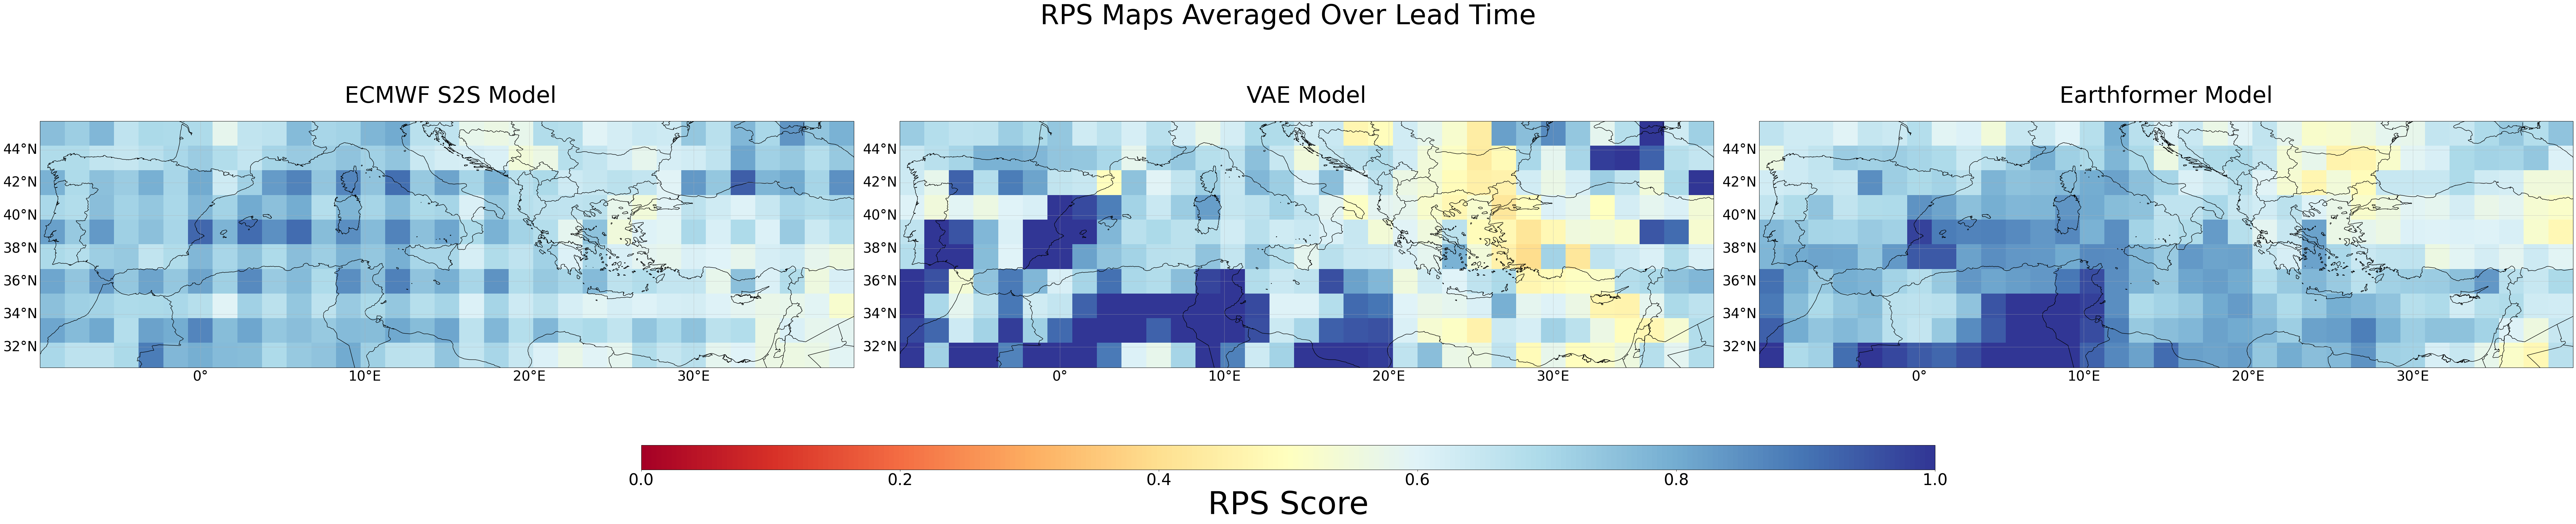

In [30]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Supposons que rps_s2s, rps_vae, et rps_earthformer sont des DataArrays xarray
# Calculons la moyenne sur la dimension du temps de prévision
rps_s2s_mean = rps_s2s.mean(dim='lead')["tp"]
rps_vae_mean = rps_vae.mean(dim='lead')["tp"]
rps_earthformer_mean = rps_earthformer.mean(dim='lead')["tp"]

# Augmenter la taille de la figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(79, 15), subplot_kw={'projection': ccrs.PlateCarree()})  # Triple the size
fig.suptitle('RPS Maps Averaged Over Lead Time', fontsize=60)  # Increase title font size

# Fonction pour ajouter les caractéristiques de la carte à chaque sous-graphique
def add_map_features(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 30}  # Increase x-axis tick label font size
    gl.ylabel_style = {'fontsize': 30}  # Increase y-axis tick label font size

vmin = 0
vmax = 1

# Plot pour S2S
im1 = ax1.pcolormesh(rps_s2s_mean.longitude, rps_s2s_mean.latitude, rps_s2s_mean.values, 
                     transform=ccrs.PlateCarree(), cmap='RdYlBu', vmin=0, vmax=vmax)
ax1.set_title(' ECMWF S2S Model', fontsize=50, pad =40)  # Increase subplot title font size
add_map_features(ax1)

# Plot pour VAE
im2 = ax2.pcolormesh(rps_vae_mean.longitude, rps_vae_mean.latitude, rps_vae_mean.values, 
                     transform=ccrs.PlateCarree(), cmap='RdYlBu', vmin=0, vmax=vmax)
ax2.set_title('VAE Model', fontsize=50, pad=40)  # Increase subplot title font size
add_map_features(ax2)

# Plot pour Earthformer
im3 = ax3.pcolormesh(rps_earthformer_mean.longitude, rps_earthformer_mean.latitude, rps_earthformer_mean.values, 
                     transform=ccrs.PlateCarree(), cmap='RdYlBu', vmin=0, vmax=vmax)
ax3.set_title('Earthformer Model', fontsize=50, pad = 40) # Increase subplot title font size
add_map_features(ax3)

# Ajout d'une barre de couleur commune en bas de la figure
# Create an additional axis for the colorbar
cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.05])  # Reduce width (0.5) and increase height (0.05)

cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('RPS Score', fontsize=70)  # Increase colorbar label font size
cbar.ax.tick_params(labelsize=35)  # Increase colorbar tick label font size

# Ajuster la mise en page pour que tout soit visible
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to leave more space for the colorbar and title

plt.show()


In [31]:
rpss = 1 - rps_vae_mean / rps_clim.tp.mean(dim='lead')

rpss.mean()

# rpss_s2s = 1 - rps_s2s_mean / rps_clim.tp.mean(dim='lead')

rpss_earthformer = 1 - rps_earthformer_mean / rps_clim.tp.mean(dim='lead')

rpss_earthformer.mean()





<xarray.DataArray 'tp' ()>
array(-0.53330421)
Coordinates:
    observations_category_edge  <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    forecasts_category_edge     <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    skill                       <U11 'initialized'

In [32]:
rpss_s2s = 1 - rps_s2s_mean / rps_clim.tp.mean(dim='lead')
rpss_s2s.mean()

<xarray.DataArray 'tp' ()>
array(-0.49195729)
Coordinates:
    observations_category_edge  <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    forecasts_category_edge     <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    skill                       <U11 'initialized'

In [33]:
rpss_vae = 1 - rps_vae_mean / rps_clim.tp.mean(dim='lead')

rpss_vae.mean()

<xarray.DataArray 'tp' ()>
array(-0.49800214)
Coordinates:
    observations_category_edge  <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    forecasts_category_edge     <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    skill                       <U11 'initialized'

In [34]:
s2s_tp = s2s_tp.isel(realization = range(50))
s2s_tp

<xarray.DataArray 'tp' (realization: 50, forecast_time: 115, lead_time: 4,
                        latitude: 10, longitude: 33)>
array([[[[[ 5.063843, ...,  0.500488],
          ...,
          [71.12909 , ..., 56.52643 ]],

         ...,

         [[15.721375, ...,  1.678101],
          ...,
          [47.988586, ..., 24.082642]]],


        ...,


        [[[ 6.624207, ...,  8.302307],
          ...,
          [50.04944 , ...,  1.501465]],

         ...,

         [[ 0.176636, ...,  0.41217 ],
          ...,
          [56.08484 , ...,  5.947083]]]],



       ...,



       [[[[      nan, ...,       nan],
          ...,
          [      nan, ...,       nan]],

         ...,

         [[      nan, ...,       nan],
          ...,
          [      nan, ...,       nan]]],


        ...,


        [[[ 8.18457 , ...,  2.679138],
          ...,
          [65.59424 , ...,  2.973511]],

         ...,

         [[ 0.264954, ...,  0.883179],
          ...,
          [42.100403, ..., 31.590088]]]]], dtype=float32)
Coordinates:
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * forecast_time  (forecast_time) datetime64[ns] 2016-01-02 ... 2020-12-03
    valid_time     (forecast_time, lead_time) datetime64[ns] ...
  * longitude      (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 36.0 37.5 39.0
  * lead_time      (lead_time) float64 7.0 14.0 21.0 28.0
Attributes: (12/31)
    GRIB_paramId:                             228228
    GRIB_dataType:                            pf
    GRIB_numberOfPoints:                      29040
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         11
    GRIB_units:                               kg m**-2
    long_name:                                Total Precipitation
    units:                                    mm
    standard_name:                            unknown
    cell_method:                              lead_time: sum

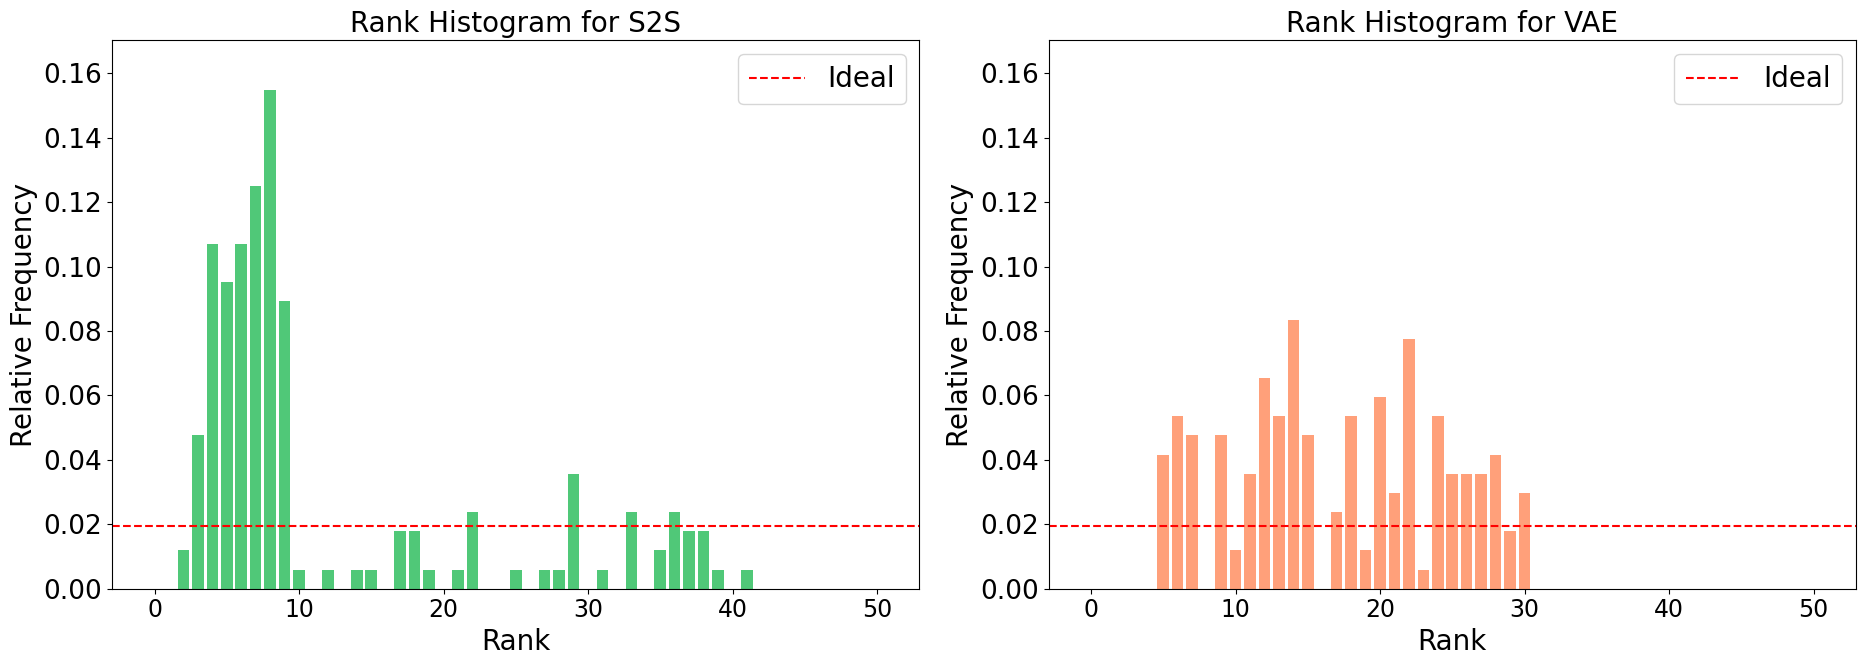

In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, FormatStrFormatter


# ... [Previous color definitions and functions remain unchanged] ...
def align_data(datasets, obs):
    """
    Align multiple datasets and observations along the forecast_time dimension.
    
    Parameters:
    datasets (list): List of xarray.DataArrays containing ensemble forecasts
    obs (xarray.DataArray): Observation data
    
    Returns:
    tuple: Aligned datasets and observations
    """
    # Find common forecast times
    common_times = set(datasets[0].forecast_time.values)
    for ds in datasets[1:]:
        common_times &= set(ds.forecast_time.values)
    common_times &= set(obs.forecast_time.values)
    common_times = sorted(list(common_times))

    # Align datasets
    aligned_datasets = [ds.sel(forecast_time=common_times) for ds in datasets]
    aligned_obs = obs.sel(forecast_time=common_times)

    return aligned_datasets, aligned_obs

def compute_rank_histogram(ensemble, observations):
    """
    Compute rank histogram for a given ensemble forecast and observations.
    
    Parameters:
    ensemble (xarray.DataArray): Ensemble forecast data
    observations (xarray.DataArray): Observation data
    
    Returns:
    numpy.ndarray: Rank histogram counts
    """
    n_members = ensemble.sizes['realization']
    ranks = xr.apply_ufunc(
        lambda x, o: np.searchsorted(np.sort(x), o),
        ensemble, observations,
        input_core_dims=[['realization'], []],
        vectorize=True
    ).tp

    
    ranks_spatial_avg = ranks.mean(dim=['latitude', 'longitude'])
    ranks_flattened = ranks_spatial_avg.stack(time=['forecast_time', 'lead_time'])
    ranks_flattened_np = ranks_flattened.values.flatten()

    hist, _ = np.histogram(ranks_flattened_np, bins=n_members + 1, range=(-0.5, n_members + 0.5))
    return hist


def plot_rank_histograms_s2s_vae(s2s_data, vae_data, obs):
    """
    Plot rank histograms for S2S and VAE models side by side with reduced y-axis ticks.
    
    Parameters:
    s2s_data (xarray.DataArray): S2S ensemble forecast data
    vae_data (xarray.DataArray): VAE ensemble forecast data
    obs (xarray.DataArray): Observation data
    """
    # Align data
    aligned_datasets, aligned_obs = align_data([s2s_data, vae_data], obs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 7))
    
    max_freq = 0  # To store the maximum frequency for y-axis scaling
    
    for data, name, color, ax in zip(aligned_datasets, ['S2S', 'VAE'], [s2s_color, vae_color], [ax1, ax2]):
        # Compute rank histogram
        rank_hist = compute_rank_histogram(data, aligned_obs)
        rank_hist_normalized = rank_hist / rank_hist.sum()
        
        max_freq = max(max_freq, np.max(rank_hist_normalized))
        
        ax.bar(range(len(rank_hist)), rank_hist_normalized, color=color)
        ax.set_title(f'Rank Histogram for {name}')
        ax.axhline(1 / (len(rank_hist)), color='r', linestyle='--', label='Ideal')
        ax.legend()
        
        # Set x-axis ticks every 10 ranks, including 0 and the last rank
        n_ranks = len(rank_hist)
        tick_locations = list(range(0, n_ranks, 10))
        if n_ranks - 1 not in tick_locations:
            tick_locations.append(n_ranks - 1)
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(tick_locations)
        
        # Ensure all x-ticks are integers
        ax.xaxis.set_major_locator(plt.FixedLocator(tick_locations))
        ax.xaxis.set_major_formatter(plt.FixedFormatter([str(x) for x in tick_locations]))
        
        # Set axis labels
        ax.set_xlabel('Rank')
        ax.set_ylabel('Relative Frequency')
        
        # Reduce number of y-axis ticks
        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # Set the same y-axis scale for both plots
    y_max = max_freq * 1.1  # Add 10% padding to the top
    ax1.set_ylim(0, y_max)
    ax2.set_ylim(0, y_max)
    
    plt.tight_layout()
    plt.show()

plot_rank_histograms_s2s_vae(s2s_tp, vae_regridded, obs_regridded)

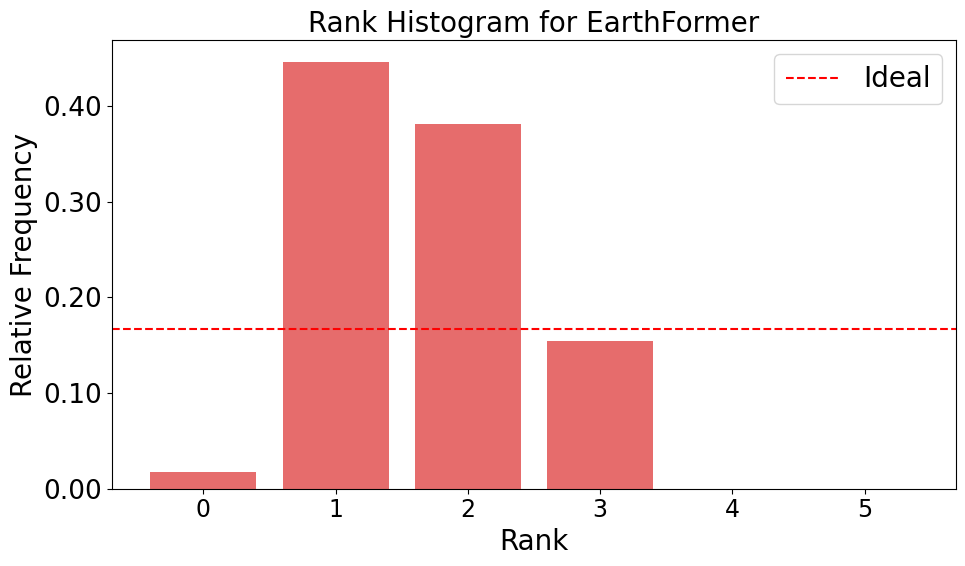

In [36]:
def plot_rank_histogram_earthformer(earthformer_data, obs):
    """
    Plot rank histogram for EarthFormer model.
    """
    # Align data
    aligned_datasets, aligned_obs = align_data([earthformer_data], obs)
    earthformer_aligned = aligned_datasets[0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Compute rank histogram
    rank_hist = compute_rank_histogram(earthformer_aligned, aligned_obs)
    rank_hist_normalized = rank_hist / rank_hist.sum()
    
    ax.bar(range(len(rank_hist)), rank_hist_normalized, color=earthformer_color)
    ax.set_title('Rank Histogram for EarthFormer')
    ax.axhline(1 / (len(rank_hist)), color='r', linestyle='--', label='Ideal')
    ax.legend()
    
    # Set x-axis ticks every 1 rank (EarthFormer has fewer members)
    n_ranks = len(rank_hist)
    ax.set_xticks(range(n_ranks))
    ax.set_xticklabels(range(n_ranks))
    
    # Set axis labels
    ax.set_xlabel('Rank')
    ax.set_ylabel('Relative Frequency')
    
    # Reduce number of y-axis ticks
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.tight_layout()
    plt.show()

plot_rank_histogram_earthformer(earthformer_regridded, obs_regridded)

In [37]:
import xarray as xr
import numpy as np
import pandas as pd

def compute_stochastic(forecast, obs, obs_edges, clim):
    """
    Calcule les métriques stochastiques (RPSS, BSS) pour les prévisions météorologiques.
    
    Parameters:
    forecast (xarray.DataArray): Prévisions (s2s_tp, vae_regridded, ou earthformer_regridded)
    obs (xarray.DataArray): Observations (obs_regridded)
    obs_edges (xarray.DataArray): Quantiles des observations (obs_edges_regridded)
    clim (xarray.DataArray): Climatologie (clim_ensemble)
    
    Returns:
    dict: Dictionnaire contenant RPSS et BSS moyennés sur forecast_time
    """
    
    def _calculate_ensemble_probabilities(ensemble, obs_edges):
        # Calculate ensemble probabilities for different categories
        probs = [
            (ensemble <= obs_edges.isel(category_edge=0)).mean(dim='realization'),
            ((ensemble > obs_edges.isel(category_edge=0)) & (ensemble <= obs_edges.isel(category_edge=1))).mean(dim='realization'),
            (ensemble > obs_edges.isel(category_edge=1)).mean(dim='realization')
        ]
        # Adjust middle category
        probs[1] = probs[1].assign_coords(category_edge=0.5)
        return xr.concat(probs, dim=pd.Index(['below', 'middle', 'above'], name='category'))

    def _categorize_observations(obs, obs_edges):
        # Categorize observations into the category_edge-based categories
        cats = [
            (obs <= obs_edges.isel(category_edge=0)),
            (obs > obs_edges.isel(category_edge=0)) & (obs <= obs_edges.isel(category_edge=1)),
            (obs > obs_edges.isel(category_edge=1))
        ]
        # Assign middle category category_edge
        cats[1] = cats[1].assign_coords(category_edge=0.5)
        return xr.concat(cats, dim=pd.Index(['below', 'middle', 'above'], name='category')).astype(int)

    def compute_rps(forecast_probabilities, obs_categorical):
        # Calculate Ranked Probability Score (RPS)
        return ((forecast_probabilities.cumsum(dim='category') - obs_categorical.cumsum(dim='category')) ** 2).mean(dim='category')

    # Categorize the observations and calculate forecast probabilities for each category
    obs_categorical = _categorize_observations(obs, obs_edges)
    forecast_prob = _calculate_ensemble_probabilities(forecast, obs_edges)
    clim_prob = _calculate_ensemble_probabilities(clim, obs_edges)

    # Compute RPSS
    forecast_rps = compute_rps(forecast_prob, obs_categorical).mean(dim='forecast_time')
    clim_rps = compute_rps(clim_prob, obs_categorical).mean(dim='forecast_time')
    rpss = 1 - (forecast_rps / clim_rps)

    # Brier Score for upper tercile
    upper_tercile = obs_edges.isel(category_edge=1)

    obs_upper = (obs > upper_tercile).astype(float)
    forecast_upper = (forecast > upper_tercile).mean(dim='realization')
    bs = ((forecast_upper - obs_upper) ** 2).mean(dim='forecast_time')

    clim_upper = (clim > upper_tercile).mean(dim='realization')
    bs_clim = ((clim_upper - obs_upper) ** 2).mean(dim='forecast_time')
    bss = 1 - (bs / bs_clim)

    lower_tercile = obs_edges.isel(category_edge=0)
    print("lower_tercile", lower_tercile)
    obs_lower = (obs <= lower_tercile).astype(float)
    forecast_lower = (forecast <= lower_tercile).mean(dim='realization')
    bs_lower = ((forecast_lower - obs_lower) ** 2).mean(dim='forecast_time')

    clim_lower = (clim <= lower_tercile).mean(dim='realization')
    bs_clim_lower = ((clim_lower - obs_lower) ** 2).mean(dim='forecast_time')
    bss_lower = 1 - (bs_lower / bs_clim_lower)


    return {'rpss': rpss, 'bss_uper': bss, 'bss_lower': bs_lower}


In [38]:
s2s_metrics = compute_stochastic(s2s_tp, obs_regridded, obs_edges_regridded, clim_ensemble)
vae_metrics = compute_stochastic(vae_regridded, obs_regridded, obs_edges_regridded, clim_ensemble)
earthformer_metrics = compute_stochastic(earthformer_regridded, obs_regridded, obs_edges_regridded, clim_ensemble)

lower_tercile <xarray.Dataset>
Dimensions:        (longitude: 33, latitude: 10)
Coordinates:
    category_edge  float64 0.3333
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * longitude      (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 36.0 37.5 39.0
Data variables:
    tp             (longitude, latitude) float64 1.464 1.189 ... 17.09 6.636
lower_tercile <xarray.Dataset>
Dimensions:        (longitude: 33, latitude: 10)
Coordinates:
    category_edge  float64 0.3333
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * longitude      (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 36.0 37.5 39.0
Data variables:
    tp             (longitude, latitude) float64 1.464 1.189 ... 17.09 6.636
lower_tercile <xarray.Dataset>
Dimensions:        (longitude: 33, latitude: 10)
Coordinates:
    category_edge  float64 0.3333
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * longitude      (longitude) float64 -9.0 -7

/scratch-local/69627/ipykernel_1800981/2893846437.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to leave more space for the colorbar and title


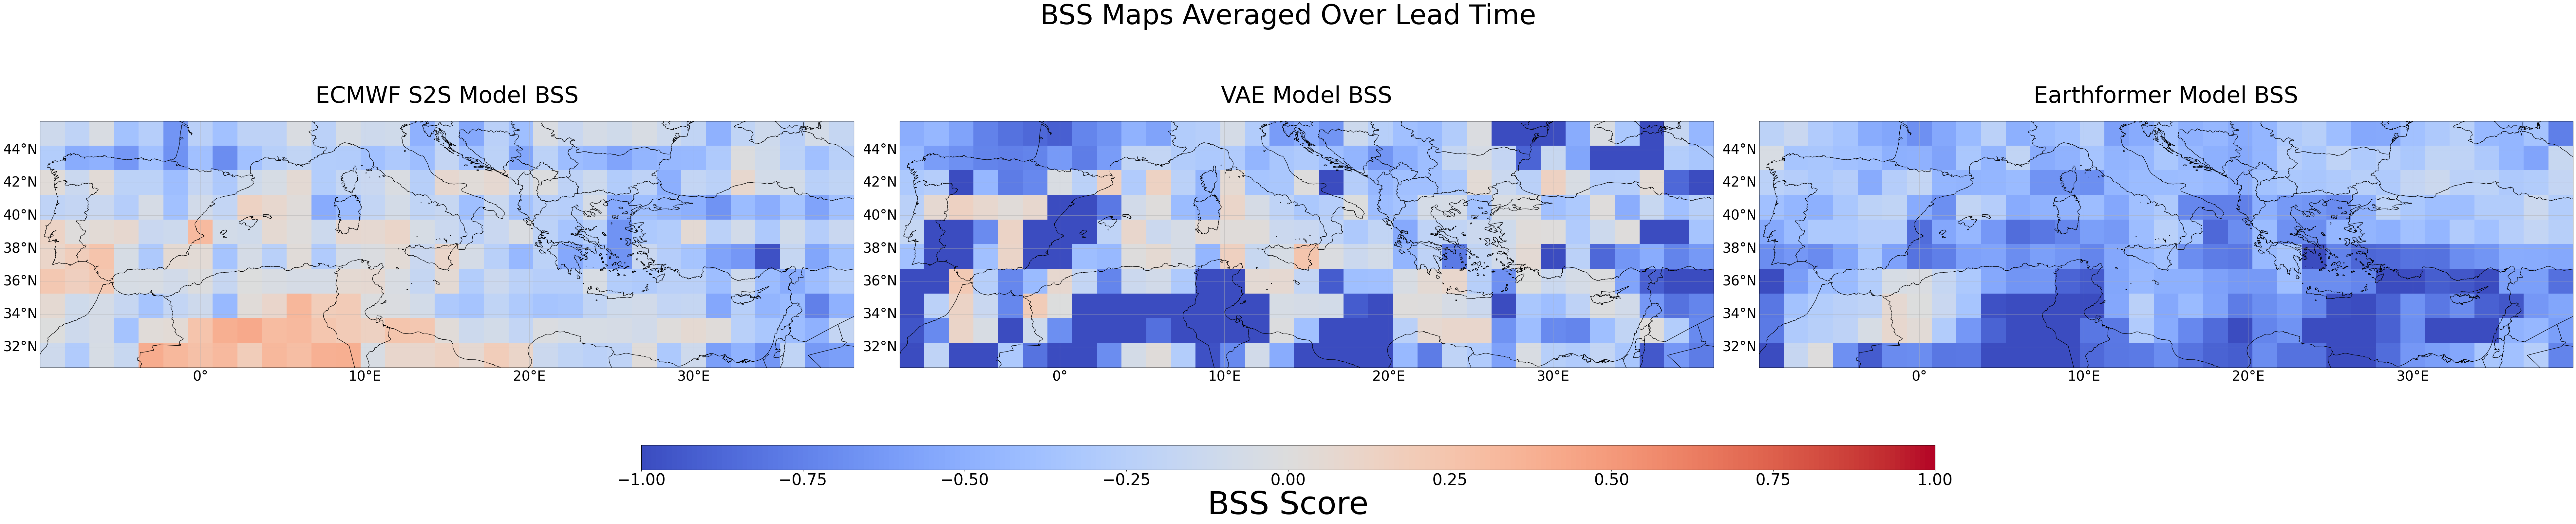

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Supposons que bss_s2s, bss_vae, et bss_earthformer sont des DataArrays xarray
# Calculons la moyenne sur la dimension du temps de prévision
bss_s2s_mean = s2s_metrics["bss_uper"].mean(dim='lead_time')["tp"]
bss_vae_mean = vae_metrics["bss_uper"].mean(dim='lead_time')["tp"]
bss_earthformer_mean = earthformer_metrics["bss_uper"].mean(dim='lead_time')["tp"]

# Augmenter la taille de la figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(79, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('BSS Maps Averaged Over Lead Time', fontsize=60)  # Title for BSS maps

# Fonction pour ajouter les caractéristiques de la carte à chaque sous-graphique
def add_map_features(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 30}  # Increase x-axis tick label font size
    gl.ylabel_style = {'fontsize': 30}  # Increase y-axis tick label font size

# Set limits for BSS (typically ranges from -1 to 1)
vmin = -1
vmax = 1

# Plot pour BSS S2S
im1 = ax1.pcolormesh(bss_s2s_mean.longitude, bss_s2s_mean.latitude, np.transpose(bss_s2s_mean.values), 
                     transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax1.set_title('ECMWF S2S Model BSS', fontsize=50, pad=40)
add_map_features(ax1)

# Plot pour BSS VAE
im2 = ax2.pcolormesh(bss_vae_mean.longitude, bss_vae_mean.latitude, np.transpose(bss_vae_mean.values), 
                     transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax2.set_title('VAE Model BSS', fontsize=50, pad=40)
add_map_features(ax2)

# Plot pour BSS Earthformer
im3 = ax3.pcolormesh(bss_earthformer_mean.longitude, bss_earthformer_mean.latitude, np.transpose(bss_earthformer_mean.values), 
                     transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax3.set_title('Earthformer Model BSS', fontsize=50, pad=40)
add_map_features(ax3)

# Ajout d'une barre de couleur commune en bas de la figure
cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.05])  # Reduce width (0.5) and increase height (0.05)
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('BSS Score', fontsize=70)  # Increase colorbar label font size
cbar.ax.tick_params(labelsize=35)  # Increase colorbar tick label font size

# Ajuster la mise en page pour que tout soit visible
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to leave more space for the colorbar and title

plt.show()


/scratch-local/69627/ipykernel_1800981/3140088945.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2, w_pad=3.0, rect=[0, 0, 0.9, 0.98])


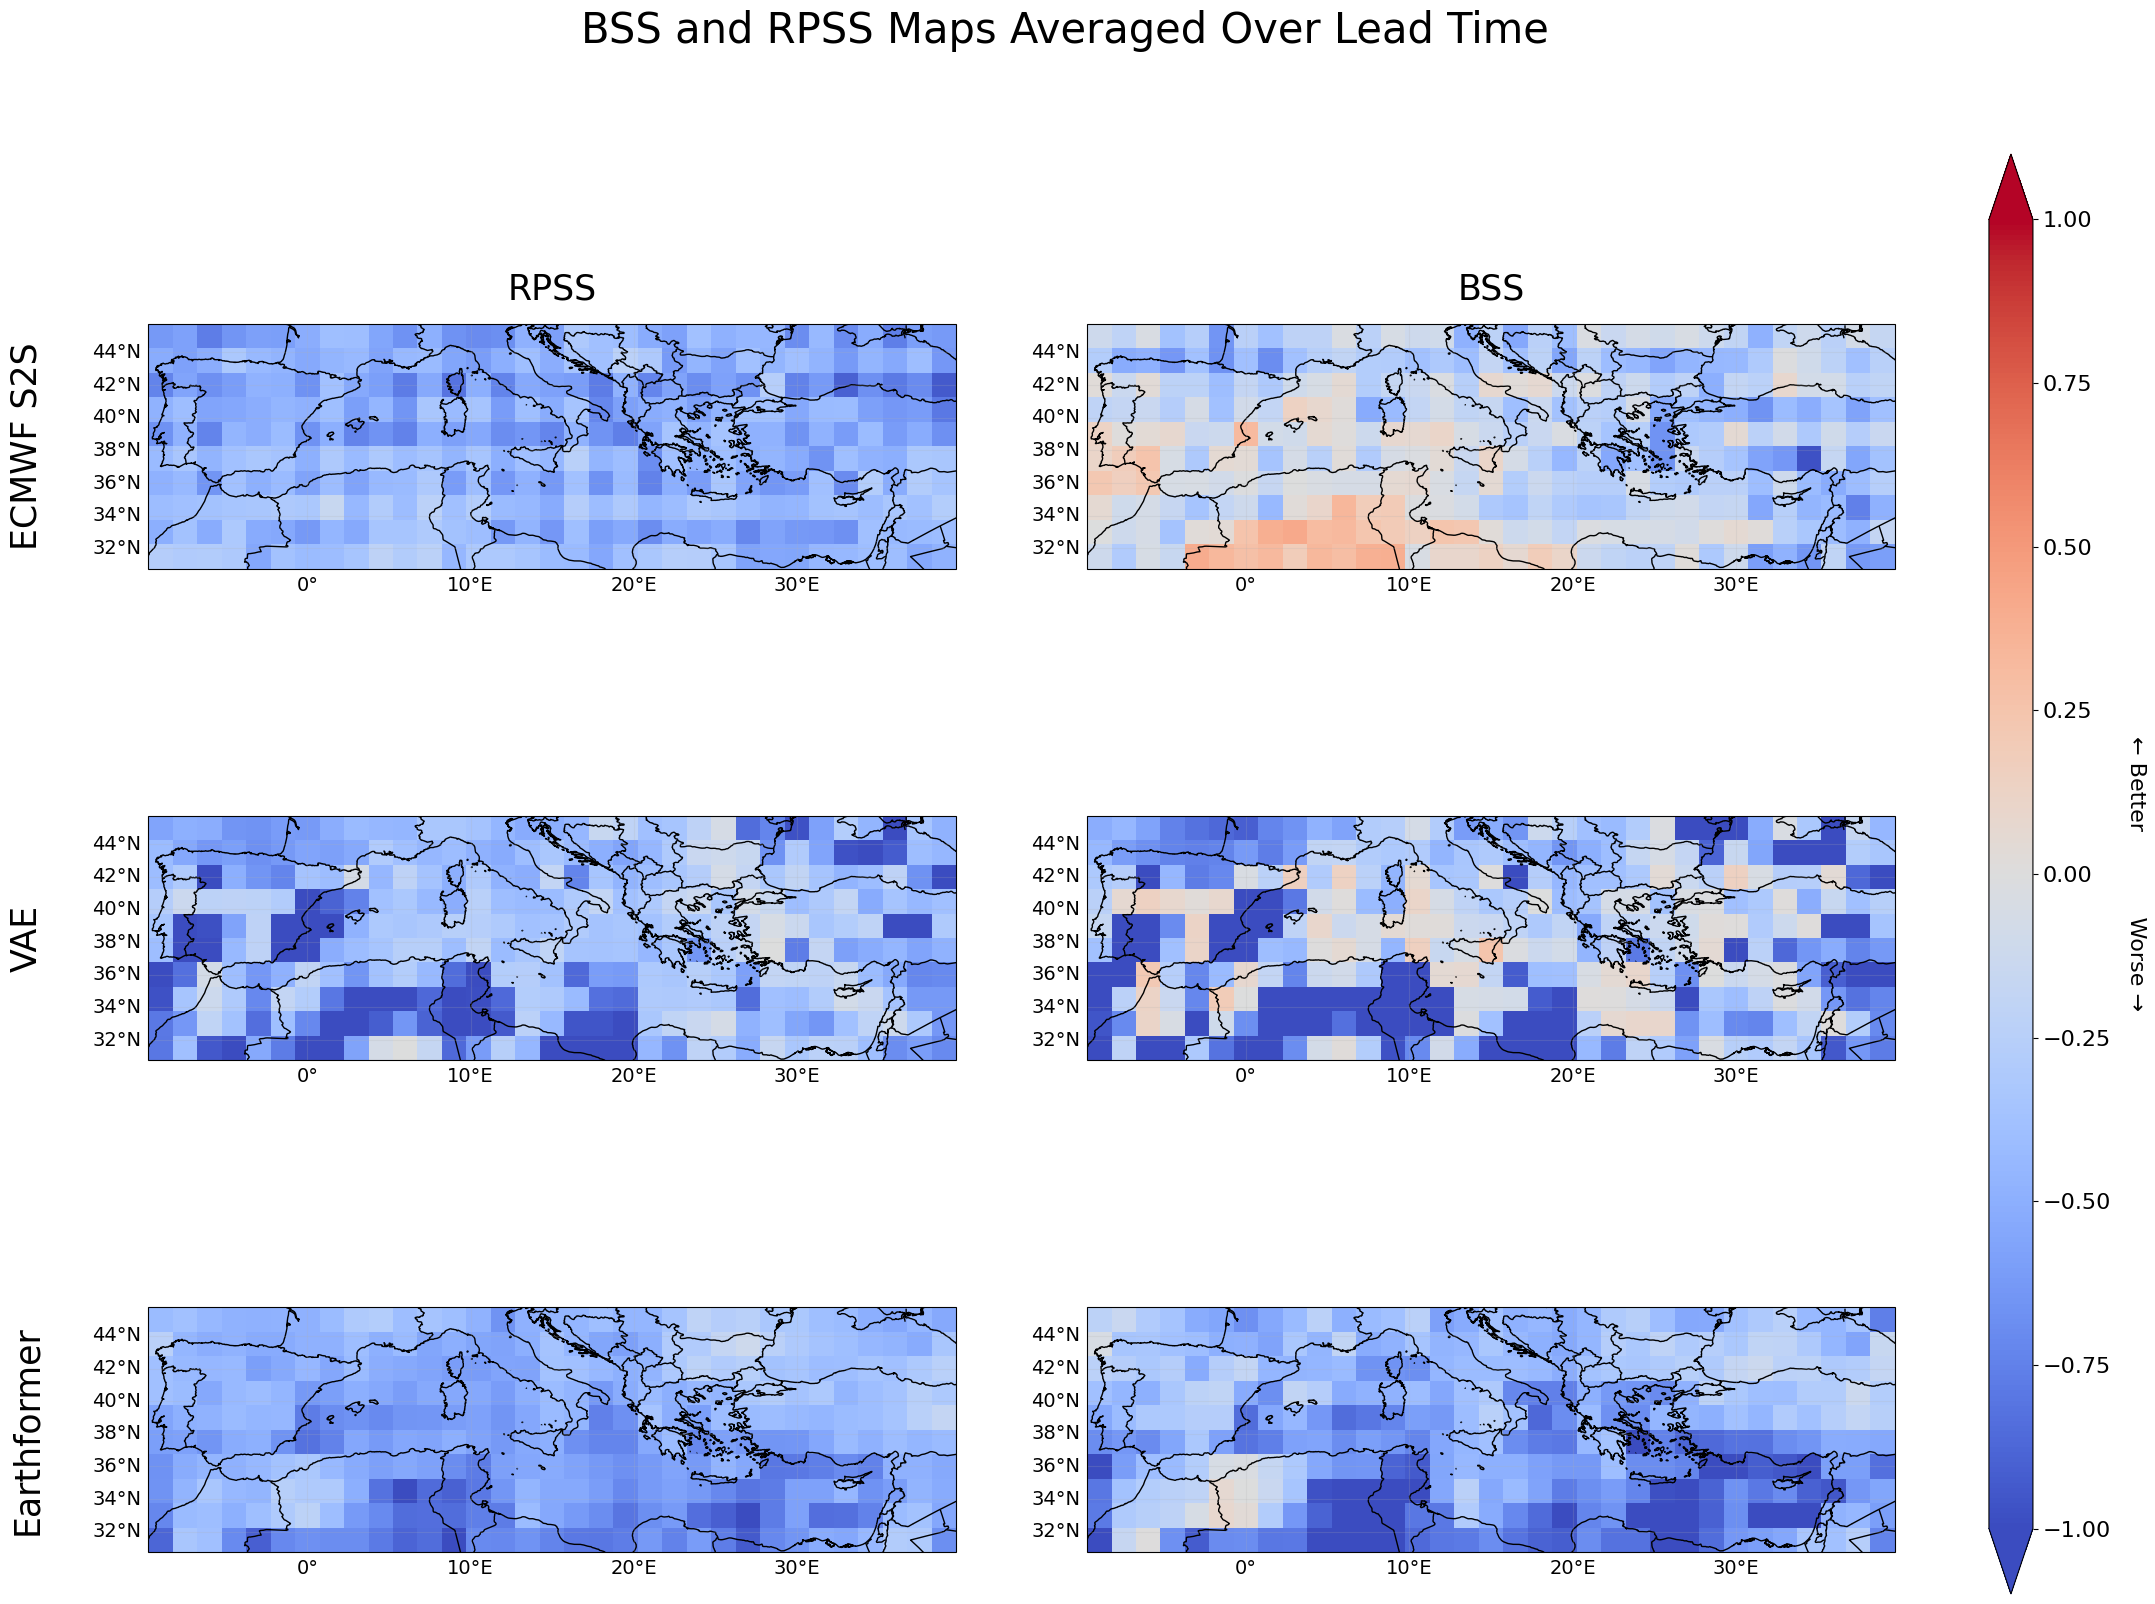

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming bss_s2s_mean, bss_vae_mean, bss_earthformer_mean, rpss_s2s, rpss_vae, and rpss_earthformer are xarray DataArrays

# Set up the figure with increased width and height for better visibility
fig, axs = plt.subplots(3, 2, figsize=(22, 18), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('BSS and RPSS Maps Averaged Over Lead Time', fontsize=30)

# Function to add map features to each subplot
def add_map_features(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.2)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}

# Set limits for BSS and RPSS
vmin, vmax = -1, 1

# List of models and their corresponding data
models = ['ECMWF S2S', 'VAE', 'Earthformer']
bss_data = [bss_s2s_mean, bss_vae_mean, bss_earthformer_mean]
rpss_data = [rpss_s2s, rpss_vae, rpss_earthformer]

# Plot RPSS and BSS for each model
for i, (model, bss, rpss) in enumerate(zip(models, bss_data, rpss_data)):
    # RPSS plot (first column)
    im_rpss = axs[i, 0].pcolormesh(rpss.longitude, rpss.latitude, rpss.values, 
                                   transform=ccrs.PlateCarree(), cmap='coolwarm', 
                                   vmin=vmin, vmax=vmax)
    add_map_features(axs[i, 0])
    
    # BSS plot (second column)
    im_bss = axs[i, 1].pcolormesh(bss.longitude, bss.latitude, np.transpose(bss.values), 
                                  transform=ccrs.PlateCarree(), cmap='coolwarm', 
                                  vmin=vmin, vmax=vmax)
    add_map_features(axs[i, 1])

# Add column titles
axs[0, 0].annotate('RPSS', xy=(0.5, 1.1), xycoords='axes fraction', fontsize=25, ha='center')
axs[0, 1].annotate('BSS', xy=(0.5, 1.1), xycoords='axes fraction', fontsize=25, ha='center')

# Add row titles for each model
for i, model in enumerate(models):
    axs[i, 0].annotate(model, xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=25, ha='center', va='center', rotation=90)

# Add a single colorbar with arrow extensions on both ends
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Single colorbar for both BSS and RPSS
cbar = fig.colorbar(im_bss, cax=cbar_ax, orientation='vertical', extend='both')
cbar.set_label('Skill Score', fontsize=18)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('← Better            Worse →', fontsize=16, rotation=270, labelpad=25)

# Adjust layout to make the plots wider and space them more evenly
plt.tight_layout(pad=2, w_pad=3.0, rect=[0, 0, 0.9, 0.98])

plt.show()


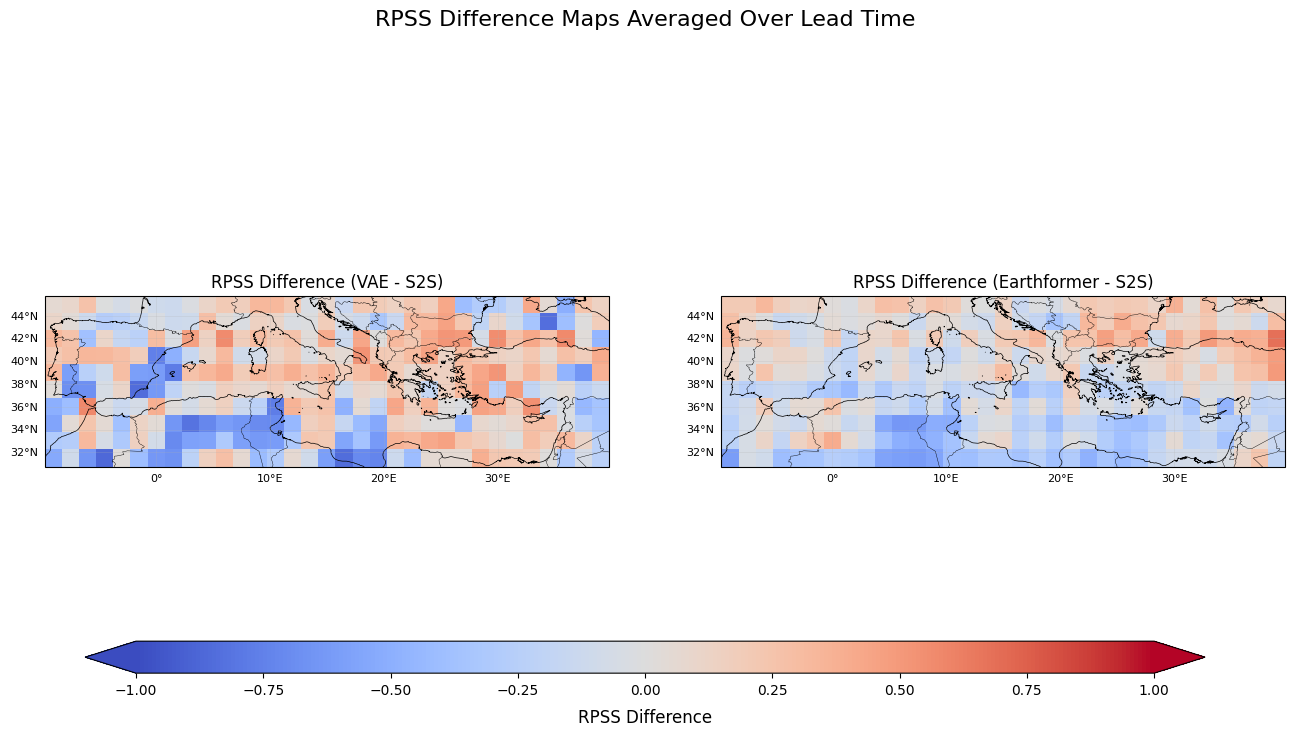

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

cmap = 'coolwarm'

rpss_diff_vae = rpss_vae - rpss_s2s
rpss_diff_earthformer = rpss_earthformer - rpss_s2s

# Function to add map features to each subplot
def add_map_features(ax):
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3, linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 8}
    gl.ylabel_style = {'fontsize': 8}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

fig.suptitle('RPSS Difference Maps Averaged Over Lead Time', fontsize=16)  # Adjusted title position

# Set limits for RPSS difference
vmin_diff, vmax_diff = - 1,1

# Plot RPSS difference for VAE
im_vae = ax1.pcolormesh(rpss_diff_vae.longitude, rpss_diff_vae.latitude, rpss_diff_vae.values, 
                        transform=ccrs.PlateCarree(), cmap=cmap, 
                        vmin=vmin_diff, vmax=vmax_diff)
ax1.set_title('RPSS Difference (VAE - S2S)', fontsize=12)
add_map_features(ax1)

# Plot RPSS difference for Earthformer
im_earthformer = ax2.pcolormesh(rpss_diff_earthformer.longitude, rpss_diff_earthformer.latitude, rpss_diff_earthformer.values, 
                                transform=ccrs.PlateCarree(), cmap=cmap, 
                                vmin=vmin_diff, vmax=vmax_diff)
ax2.set_title('RPSS Difference (Earthformer - S2S)', fontsize=12)
add_map_features(ax2)

# Add a smaller colorbar closer to the maps
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.04])  # Reduced height to 0.02
cbar = fig.colorbar(im_vae, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('RPSS Difference', fontsize=12, labelpad=8)
cbar.ax.tick_params(labelsize=10)

# Adjust layout to remove extra whitespace
fig.subplots_adjust(bottom=0.15, top=0.88)

# Save or display the figure
plt.savefig('rpss_difference_maps_thick_colorbar_reduced_space.png', dpi=300, bbox_inches='tight')
plt.show()



In [42]:
lead_times

[7, 14, 21, 28]

In [43]:
obs_regridded.std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 45.23

In [44]:
vae_regridded.std()

<xarray.DataArray 'tp' ()>
array(22.89422777)

## Spatial ACC

In [45]:
def compute_spatial_acc(forecast, observations, clim_mean):
    
    forecast_anomaly = (forecast - clim_mean) 
    obs_anomaly = (observations - clim_mean)
    
    numerator = (forecast_anomaly * obs_anomaly).mean(dim=['forecast_time', 'lead_time', 'realization'])
    denominator = np.sqrt((forecast_anomaly**2).mean(dim=['forecast_time', 'lead_time', 'realization']) * (obs_anomaly**2).mean(dim=['forecast_time', 'lead_time']))
    
    return numerator / denominator

s2s_spatial_acc = compute_spatial_acc(s2s_tp, obs_regridded, clim_mean_regridded)
vae_spatial_acc = compute_spatial_acc(vae_regridded, obs_regridded, clim_mean_regridded)
earthformer_spatial_acc = compute_spatial_acc(earthformer_regridded, obs_regridded, clim_mean_regridded)

# faire la moyenne sur les forecast_time and realization
s2s_spatial_acc = s2s_spatial_acc["tp"]
vae_spatial_acc = vae_spatial_acc["tp"]
earthformer_spatial_acc = earthformer_spatial_acc["tp"]



/scratch-local/69627/ipykernel_1800981/3507222322.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space for the title and the colorbar


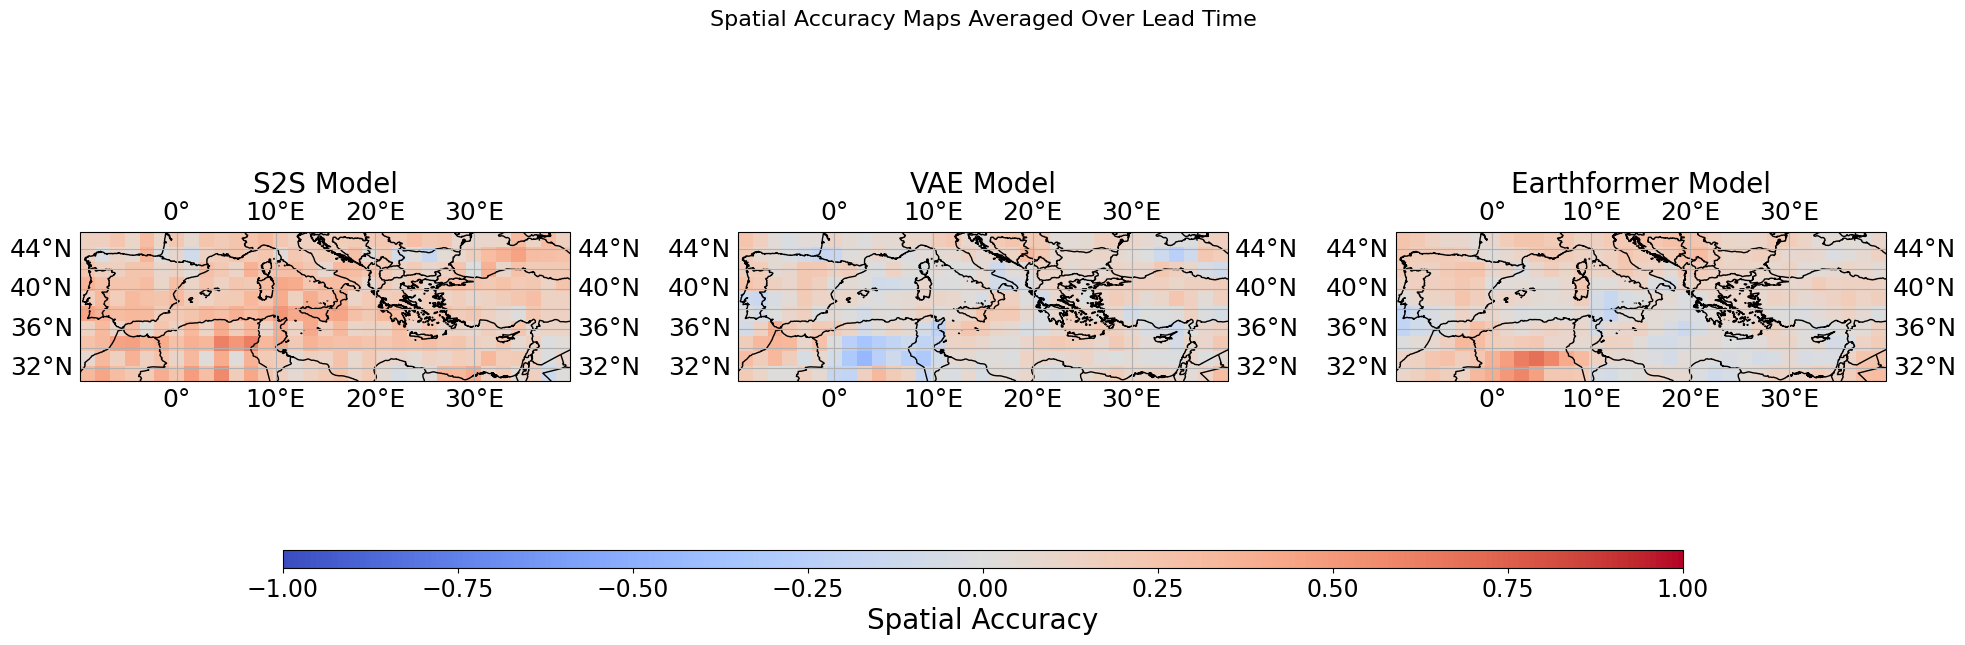

In [46]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Créons une figure avec trois sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Spatial Accuracy Maps Averaged Over Lead Time', fontsize=16)

# Fonction pour ajouter les caractéristiques de la carte à chaque sous-graphique
def add_map_features(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True)

# Définir les limites de couleur pour l'exactitude spatiale
vmin = -1
vmax = 1

# Plot pour le modèle S2S
im1 = ax1.pcolormesh(s2s_spatial_acc.longitude, s2s_spatial_acc.latitude, s2s_spatial_acc.values,
                     transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto')
ax1.set_title('S2S Model')
add_map_features(ax1)

# Plot pour le modèle VAE
im2 = ax2.pcolormesh(vae_spatial_acc.longitude, vae_spatial_acc.latitude, vae_spatial_acc.values,
                     transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto')
ax2.set_title('VAE Model')
add_map_features(ax2)

# Plot pour le modèle Earthformer
im3 = ax3.pcolormesh(earthformer_spatial_acc.longitude, earthformer_spatial_acc.latitude, earthformer_spatial_acc.values,
                     transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto')
ax3.set_title('Earthformer Model')
add_map_features(ax3)

# Ajout d'une barre de couleur commune en bas de la figure
# Create an additional axis for the colorbar
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]

cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Spatial Accuracy')

# Ajuster la mise en page pour que tout soit visible
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space for the title and the colorbar

plt.show()


In [47]:
earthformer_spatial_acc.mean()


<xarray.DataArray 'tp' ()>
array(0.1083243)

In [48]:
vae_regridded

<xarray.DataArray 'tp' (forecast_time: 42, lead_time: 4, realization: 50,
                        latitude: 10, longitude: 33)>
array([[[[[ 13.87486006,  33.79463028,  18.70443359, ...,
            17.30536355,   9.11282644,   6.92172243],
          [ 13.2821501 ,  26.4600197 ,  12.61345382, ...,
            10.35062512,   5.59075423,   3.23709092],
          [ 32.40152569,  63.97362685,  31.92260215, ...,
            38.57229865,  44.50411234,  13.85676069],
          ...,
          [ 31.06712569,  58.83744573,  25.65378404, ...,
            18.01810187,  30.24441871,  22.51265554],
          [ 58.1625929 , 120.18210942,  49.03763079, ...,
            24.58553677,  43.44972239,  36.35859367],
          [ 23.89618816,  41.34761854,  19.52651082, ...,
            11.61303934,  25.38905893,  17.99411598]],

         [[ 15.49854886,  34.99129788,  18.77325067, ...,
            18.60214325,   9.35813455,   5.72761818],
          [ 14.08172938,  26.4986402 ,  12.80643803, ...,
            11.5673249 ,   6.22566836,   2.91384747],
          [ 30.59530865,  61.78905694,  31.14480327, ...,
            41.42079939,  45.59635041,  13.69331105],
...
          [ 45.94737447,  65.03928568,  14.27317142, ...,
            17.89971538,  31.01067307,  23.09958779],
          [ 66.06592853, 119.82178259,  52.67963059, ...,
            24.35867863,  43.72647741,  37.17002548],
          [ 24.45883834,  50.30706973,  23.6081365 , ...,
            11.40669553,  24.91436435,  18.02971195]],

         [[ 14.34363554,  33.14604591,  14.8423213 , ...,
            13.54198478,   8.35125238,   5.59978582],
          [ 12.31719856,  22.46938195,  13.46500188, ...,
            11.70837423,   5.07365132,   2.63803951],
          [ 25.14697147,  54.73790611,  29.96947789, ...,
            41.68726022,  46.71129761,  14.38911998],
          ...,
          [ 43.60924922,  61.45819135,  14.23645263, ...,
            16.94770685,  29.13746447,  21.4022186 ],
          [ 63.04544469, 111.88895461,  49.15652692, ...,
            23.85429624,  41.0154236 ,  33.40261026],
          [ 22.5032711 ,  46.73214998,  21.80159893, ...,
            11.06933643,  23.41577547,  16.71282349]]]]])
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2017-01-16 ... 2020-12-03
  * lead_time      (lead_time) int64 7 14 21 28
  * realization    (realization) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * longitude      (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 36.0 37.5 39.0

In [49]:
clim_ensemble

<xarray.Dataset>
Dimensions:        (realization: 50, forecast_time: 42, lead_time: 4,
                    latitude: 10, longitude: 33)
Coordinates:
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * forecast_time  (forecast_time) datetime64[ns] 2017-01-16 ... 2020-12-03
  * lead_time      (lead_time) int64 7 14 21 28
  * latitude       (latitude) float64 31.5 33.0 34.5 36.0 ... 42.0 43.5 45.0
  * longitude      (longitude) float64 -9.0 -7.5 -6.0 -4.5 ... 36.0 37.5 39.0
Data variables:
    tp             (realization, forecast_time, lead_time, latitude, longitude) float64 ...

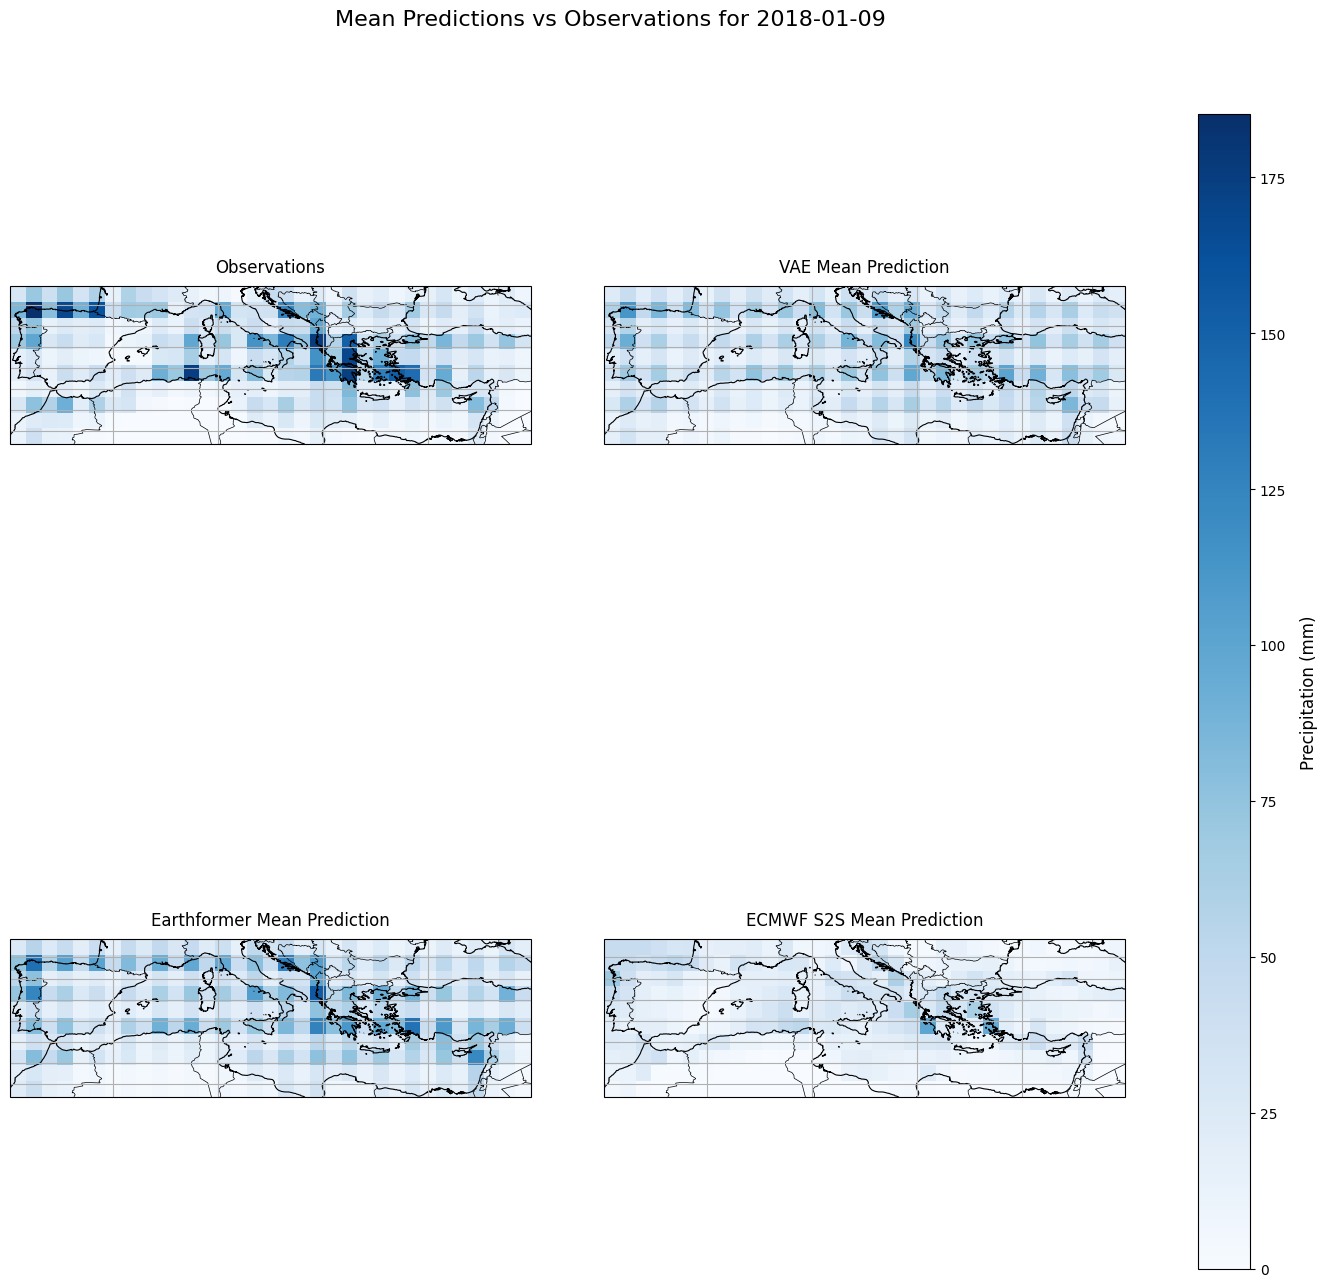

In [50]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_mean_and_obs(vae_da, earth_da, s2s_da, obs, forecast_time):
   # Create figure with more space on the right for colorbar
   fig = plt.figure(figsize=(16, 15))
   
   # Create a gridspec with space for colorbar
   gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.1], hspace=0.3, wspace=0.2)
   
   # Create axes for plots and colorbar
   axs = []
   for i in range(2):
       for j in range(2):
           ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
           axs.append(ax)
   
   # Create axis for colorbar
   cbar_ax = fig.add_subplot(gs[:, -1])
   
   fig.suptitle(f'Mean Predictions vs Observations for {forecast_time}', fontsize=16, y=0.95)
   
   # Get common min and max values for colorbar
   obs_data = obs.tp.sel(forecast_time=forecast_time).isel(lead_time=0)
   vae_mean = vae_da.sel(forecast_time=forecast_time).isel(lead_time=0).mean(dim='realization')
   earth_mean = earth_da.sel(forecast_time=forecast_time).isel(lead_time=0).mean(dim='realization')
   s2s_mean = s2s_da.sel(forecast_time=forecast_time).isel(lead_time=0).mean(dim='realization')
   
   # Calculate global min and max
   all_data = [
       np.transpose(obs_data.values),
       vae_mean.values,
       earth_mean.values,
       s2s_mean.values
   ]
   vmin = min(np.nanmin(data) for data in all_data)
   vmax = max(np.nanmax(data) for data in all_data)
   
   # Plot observations
   im_obs = axs[0].pcolormesh(obs_data.longitude, obs_data.latitude, 
                             np.transpose(obs_data.values), 
                             cmap='Blues', 
                             transform=ccrs.PlateCarree(),
                             vmin=vmin, vmax=vmax)
   axs[0].coastlines(linewidth=0.8)
   axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)
   axs[0].set_title('Observations', fontsize=12, pad=10)
   axs[0].gridlines(draw_labels=False)
   
   # Plot mean predictions for each model
   models = {
       'VAE': vae_mean,
       'Earthformer': earth_mean,
       'ECMWF S2S': s2s_mean
   }
   
   for idx, (model_name, data) in enumerate(models.items(), start=1):
       im = axs[idx].pcolormesh(data.longitude, data.latitude, 
                               data.values, 
                               cmap='Blues', 
                               transform=ccrs.PlateCarree(),
                               vmin=vmin, vmax=vmax)
       axs[idx].coastlines(linewidth=0.8)
       axs[idx].add_feature(cfeature.BORDERS, linewidth=0.5)
       axs[idx].set_title(f'{model_name} Mean Prediction', fontsize=12, pad=10)
       axs[idx].gridlines(draw_labels=False)

   # Add colorbar on the right
   cbar = fig.colorbar(im, cax=cbar_ax)
   cbar.set_label('Precipitation (mm)', fontsize=12, labelpad=10)
   cbar.ax.tick_params(labelsize=10)
   
   plt.show()

# Plot mean predictions and observations
forecast_time = "2018-01-09"

plot_mean_and_obs(vae_regridded, 
                earthformer_regridded, 
                s2s_tp_regridded, 
                obs_regridded, 
                forecast_time)